In [ ]:

#Multi-objective Bayesian optimizer import

#!pip install deap
#!pip3 install https://github.com/ppgaluzio/MOBOpt/archive/master.zip


In [1]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx
from wpca import WPCA
from sklearn.linear_model import HuberRegressor, LinearRegression
from matplotlib import cm
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import mobopt as mo
%matplotlib inline

from functools import wraps
import time


def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        return result
    return timeit_wrapper


In [2]:

def find_dist_to_closest_edge(point, edges, far=False):
    """
    point: np.array (x,y,z)
    edges: dictionary
    
    """
    min_dist = np.inf
    min_edge = None
    closest_point = None
    closest_endpoint = None
    closest_endpoint_id = None
    
    for edge, (segment_start, segment_end) in edges.items():
        
        if far: 
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp, far_endpoint, far_endpoint_id = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        else:
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge, far=far)
        
        if dist < min_dist:
            min_dist = dist
            min_edge = edge
            closest_point = closest_point_tmp
            closest_endpoint = closest_endpoint_tmp
            closest_endpoint_id = closest_endpoint_id_tmp
        
    if far:
        return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
            
    return min_dist, min_edge, closest_point, closest_endpoint, closest_endpoint_id

def distance_point_to_segment(point, segment_vector, edge, far=False):
    """
    `point` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
#     segment_vector = segment_end - segment_start
    point_vector = point 
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    if projection <= 0:
        if far:
            return np.linalg.norm(point_vector), segment_start, segment_start, edge[0], segment_end, edge[1] 
        return np.linalg.norm(point_vector), segment_start, segment_start, edge[0]
    elif projection > 1:
        if far:
             return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1], segment_start, edge[0]
            
        return np.linalg.norm(point - segment_end), segment_end, segment_end, edge[1]
    else:
        closest_point = segment_start + projection * segment_vector
        closest_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else segment_end
        closest_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) < np.linalg.norm(closest_point - segment_end) else edge[1]
        
        if far:
            far_endpoint = segment_start if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else segment_end
            far_endpoint_id = edge[0] if np.linalg.norm(closest_point - segment_start) > np.linalg.norm(closest_point - segment_end) else edge[1]
            return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id, far_endpoint, far_endpoint_id
        return np.linalg.norm(point - closest_point), closest_point, closest_endpoint, closest_endpoint_id
    
def explored_nodes_affected(nodes, edges, DST_threshold):
    for n, point in nodes.items():
        # go through all explored nodes
        # go through all edges
        min_dist = np.inf
        for edge, (segment_start, segment_end) in edges.items():
        
            dist, closest_point_tmp, closest_endpoint_tmp, closest_endpoint_id_tmp = distance_point_to_segment(point, segment_start, segment_end, edge)
            # find minimal distance
            if dist < min_dist:
                min_dist = dist
                
        # check that minimal distance is lower than the threshold
        if min_dist > DST_threshold:
            return True
        
    return False

def closer_to_seed(point, closest_endpoint, seed_coord):
    if np.linalg.norm(point - seed_coord) <  np.linalg.norm(closest_endpoint - seed_coord):
        return True
    return False

def project_lc_to_pca(point, segment_start, segment_end):
    """
    `lc` is a 1D NumPy array of length 3 representing the point;
    `segment_start` and `segment_end` are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    segment_vector = segment_end - segment_start
    #print(segment_vector)
    point_vector = point - segment_start
    #print(point_vector)
    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)

    closest_point = segment_start + projection * segment_vector
    return np.linalg.norm(point - closest_point), closest_point

In [3]:
!#pip install cv2

In [4]:

import numpy as np
from sklearn.metrics import r2_score

# def extract_lines_hough(point_cloud):
#     # Convert point cloud to grayscale image (if needed)
#     gray = cv2.cvtColor(point_cloud, cv2.COLOR_RGB2GRAY)

#     # Apply Canny edge detection to find edges
#     edges = cv2.Canny(gray, 50, 150, apertureSize=3)

#     # Apply Hough Transform to detect lines
#     lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=100, maxLineGap=10)

#     # Draw the detected lines on the original point cloud
#     line_cloud = np.copy(point_cloud)
#     if lines is not None:
#         for line in lines:
#             x1, y1, x2, y2 = line[0]
#             cv2.line(line_cloud, (x1, y1), (x2, y2), (0, 255, 0), 2)

  #  return line_cloud

def intersect_line_with_surface(line_start, line_dir, surface_z):
    # Calculate the intersection point
    t = (surface_z - line_start[2]) / line_dir[2]
    intersection_point = line_start + t * line_dir

    return intersection_point

In [5]:
class Trackster:
    def __init__(self, energy, barycenter, p0, p1, eigenvector, lcx, lcy, lcz, lce, indexLC,eta,phi):
        self.energy = energy
        self.barycenter = barycenter
        self.p0 = p0
        self.p1 = p1
        self.eigenvector = eigenvector
        self.eta = eta
        self.phi = phi
        self.lcx = lcx
        self.lcy = lcy
        self.lcz = lcz
        self.lce = lce
        self.indexLC = indexLC
        

In [6]:

def check_point_cone(h,base_radius,angle,start_point,x,y,z,eigenvector):
    test_point = np.array([x,y,z])
    base_radius_computed = np.tan(angle)*h
    cone_dist = np.dot(test_point-start_point,eigenvector)
    if cone_dist < 0 or cone_dist > h:
        # The test point is outside the length of the cone
        return False
    cone_r = (cone_dist/h)*base_radius_computed
    dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
    return dist<cone_r


def cleaningHAD(_feats, pca_algo):
    
    X = _feats
    X = np.concatenate((X,X[:,4][:, np.newaxis]), axis=1)
    X = np.concatenate((X,X[:,4][:, np.newaxis]), axis=1)  


    ####------------------------------------------------ fill array with max E LC per layer ------------------------------------------------####
    
    #Consider only layers<28 to find the maxE LC layer
    tmp = X
    maxidx = np.argmax(tmp[:,4])
    maxl = tmp[maxidx,3]
    maxe = tmp[maxidx,4]
    maxx = tmp[maxidx,0]
    maxy = tmp[maxidx,1]
    maxz = tmp[maxidx,2]

    ####------------------------------------------------ fill array with max E LC per layer for +-N layers from the maxE LC layer ------------------------------------------------####
    cleanarr = []
    for i in range(0,int(max(tmp[:,3])),1):
#         print(int(max(tmp[:,3])))
        if (len(X[:,4][X[:,3] == i])==0):
            continue
        maxeidx = np.argmax(X[:,4][X[:,3] == i])
        type_clean = X[:,-1][X[:,3] == i][maxeidx]
        if(type_clean == 8):
            continue
        
        xclean = X[:,0][X[:,3] == i][maxeidx]
        yclean = X[:,1][X[:,3] == i][maxeidx]
        zclean = X[:,2][X[:,3] == i][maxeidx]
        lclean = X[:,3][X[:,3] == i][maxeidx]
        eclean = X[:,4][X[:,3] == i][maxeidx]
        cleanarr.append([xclean,yclean,zclean,lclean,eclean,eclean,eclean]) #eclean is added three times to prepare the array for the weighted PCA
    notCleanArr = []
    

    for i in range(len(X)):
        notCleanArr.append([X[i,0], X[i,1], X[i,2], X[i,3], X[i,4],X[i,4],X[i,4]])

    cleanarr = np.array(cleanarr)
    ####------------------------------------------------ PCA with +-N layers from the maxE LC layer ------------------------------------------------####
    cleanarr_pca = cleanarr #np.array([i for i in cleanarr if i[3]<28]) # To compute the PCA axis consider only LC in the EM compartment
    if(len(cleanarr_pca) <=3):
        cleanarr_pca = np.array(notCleanArr)
    #Energy-weighted PCA
#     _,_,best_points = fit_line_ransac(cleanarr)
#     cleanarr_pca = cleanarr_pca[best_points]
    
    maxidx = np.argmax(cleanarr_pca[:,4])
    maxx = cleanarr_pca[maxidx,0]
    maxy = cleanarr_pca[maxidx,1]
    maxz = cleanarr_pca[maxidx,2]
    maxl = cleanarr_pca[maxidx,3]

    if pca_algo == 'std':
        pca = PCA(n_components=3)
        pca.fit(cleanarr_pca[:,:3])
    elif pca_algo == 'stdAllLCs':
        pca = PCA(n_components=3)
        pca.fit(X[:,:3])
    elif pca_algo == 'eWeighted':
        pca = WPCA(n_components=3)
        pca.fit(cleanarr_pca[:,:3], weights = cleanarr_pca[:,4:])
    elif pca_algo == 'eWeightedAllLCs':
        pca = WPCA(n_components=3)
        pca.fit(X[:,:3], weights = X[:,4:])


#     mincompidx = np.argmax(pca.explained_variance_)

    pca_axis = np.array([*pca.components_[0]])

    origin = [maxx,maxy,maxl,maxz]
    
    return origin, pca_axis, cleanarr_pca

In [7]:
import numpy as np
from scipy.optimize import minimize
import numpy as np
from numba import jit


def project_lc_to_pca(point, segment_vector, barycenter):
    """
    lc is a 1D NumPy array of length 3 representing the point;
    segment_start and segment_end are 1D NumPy arrays of length 3 representing the start and end points of the line segment. 
    The function returns the minimum distance between the point and the line segment and the closest point on this segment.
    """
    
    #print(segment_vector)
    point_vector = point - barycenter
    #print(point_vector)

    if not np.any(segment_vector):
        projection = 0
    else:
        projection = np.dot(point_vector, segment_vector) / np.dot(segment_vector, segment_vector)
#     print(f"Bary {barycenter}, proj {projection}, vector {segment_vector}")
    closest_point = barycenter + projection * segment_vector
    return np.linalg.norm(point - closest_point)

def huber_loss(params, points, barycenter, weights, delta):
    direction = params / np.linalg.norm(params)  # Normalize direction vector
    
    #     residuals = np.abs(np.dot(direction, points.T)) #- np.dot(points[0], direction))
    loss = 0.0
    residuals = np.zeros(len(points))
    for i in range(len(residuals)):
        residuals[i] = project_lc_to_pca(points[i], direction, barycenter)
        residual = residuals[i]
        weight = weights[i]
        if residual <= delta:
            loss += 0.5 * weight * residual**2
        else:
            loss += delta * weight * (residual - 0.5 * delta)
    return loss


def fit_line_to_point_cloud(point_cloud, barycenter, weights, delta):
    points = np.array(point_cloud)
    params_initial = np.random.rand(3)  # Initial values for direction vector
    params_history = [params_initial.copy()]  # List to store parameter values at each iteration
    loss_history = []  # List to store loss function values at each iteration

    def callback(params):
        params_normalized = params / np.linalg.norm(params)  # Normalize parameter values
        params_history.append(params_normalized.copy())
        loss = huber_loss(params_normalized, points,barycenter,  weights, delta)
        loss_history.append(loss)

    # Optimize using weighted Huber loss with callback
    result = minimize(huber_loss, params_initial, args=(points, barycenter, weights, delta), callback=callback)

    # Retrieve optimized direction vector and normalize it
    direction = result.x / np.linalg.norm(result.x)
    return direction, params_history, loss_history

def connected_components(pairs):
    components = []

    for a, b in pairs:
        for component in components:
            if a in component:
                for i, other_component in enumerate(components):
                    if b in other_component and other_component != component: 
                        component.extend(other_component)
                        components[i:i+1] = []
                        break 
                else: 
                    if b not in component:
                        component.append(b)
                break 
            if b in component: 
                component.append(a)
                break 
        else: 
#             if components:
#                 if a or b in component:
#                     break
#             else:
            components.append([a, b])
    return components

def order_pairs(pairs):
    sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
    return sorted_pairs

def check_point_cone(h,base_radius,angle,start_point,x,y,z,eigenvector):
    test_point = np.array([x,y,z])
    base_radius_computed = np.tan(angle)*h
    cone_dist = np.dot(test_point-start_point,eigenvector)
    if cone_dist < 0 or cone_dist > h:
        # The test point is outside the length of the cone
        return False
    cone_r = (cone_dist/h)*base_radius_computed
    dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
    return dist<cone_r


def flatten_array(arr):
    flattened = []
    for item in arr:
        if isinstance(item, list):
            flattened.extend(flatten_array(item))
        else:
            flattened.append(item)
    return flattened
def order_pairs(pairs):
    sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
    return sorted_pairs
def computeRatio(df1, df2):
    ratio = df1/ df2
    ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))
    return ratio, ratio_st

def recomputeError(h1, h2, NBINS):
    h1.Sumw2()
    h2.Sumw2()
    ratio = h1.Clone('h3')
    ratio.Sumw2()
    ratio.Divide(h2)
    bin_errors = []
    for i in range(ratio.GetSize()):
        bin_errors.append(ratio.GetBinError(i))
    return bin_errors

def fixError(ratio, bin_errors):
    bin_errors_asym_neg = []
    bin_errors_asym_pos = []
    for i,e in enumerate(bin_errors[1:-1]):
        div = 1
        bin_errors_asym_neg.append(e/div)
        if(e/div + ratio[i] > 1):
            bin_errors_asym_pos.append(1-ratio[i])
        else:
            bin_errors_asym_pos.append(e/div)
    return [bin_errors_asym_neg, bin_errors_asym_pos]


 

In [8]:
import awkward as ak
import glob
import numpy as np
import uproot as uproot
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import networkx as nx
from wpca import WPCA
from sklearn.linear_model import HuberRegressor, LinearRegression
from matplotlib import cm
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
#path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/PatatrackHackathon2023/CMSSW_13_X/CloseByPion0PU/histo/"
#path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/PatatrackHackathon2023/CMSSW_13_X/CloseByTwoPions0PU/histo/"
path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/PatatrackHackathon2023/CMSSW_13_X/CloseByTwoPions0PU/histo/"
files = glob.glob(path + "*.root")
trk_data_tot = []
gra_data_tot = []
ass_data_tot = []
lc_data_tot = []
simtrackstersSC_data_tot = []
simtrackstersCP_data_tot = []
for f in tqdm(files[0:-1]):
    
    file = uproot.open(f)
    
    try:
        tracks = file["ticlDumper/tracks;1"]
        tracksters = file["ticlDumper/tracksters;1"]
        simtracksters = file["ticlDumper/simtrackstersSC;1"]
        simtrackstersCP = file["ticlDumper/simtrackstersCP;1"]
        ass = file["ticlDumper/associations;1"]
        gra = file["ticlDumper/graph;1"]
        cand = file["ticlDumper/candidates;1"]
        lc = file["ticlDumper/clusters;1"]
        
    except Exception:
        continue
    trk_data = tracksters.arrays(["NTracksters", "raw_energy","raw_em_energy","barycenter_x","barycenter_y",
                              "barycenter_z","eVector0_x", "eVector0_y","eVector0_z","EV1","EV2","EV3",
                              "vertices_indexes", "sigmaPCA1", "sigmaPCA2", "sigmaPCA3", "vertices_x", "vertices_y",
                              "vertices_z", "vertices_energy","trackster_barycenter_eta","trackster_barycenter_phi","raw_pt"])
    gra_data = gra.arrays(["linked_inners", "linked_outers"])
    # ass_data = ass.arrays(["tsCLUE3D_recoToSim_SC", "tsCLUE3D_recoToSim_SC_score",
    #                       "tsCLUE3D_simToReco_SC", "tsCLUE3D_simToReco_SC_score",
    #                        "tsCLUE3D_simToReco_SC_sharedE", "tsCLUE3D_recoToSim_SC_sharedE"])

    ass_data = ass.arrays([#'tsCLUE3D_recoToSim_PU', 'tsCLUE3D_recoToSim_PU_score', 'tsCLUE3D_recoToSim_PU_sharedE',
                                                          'tsCLUE3D_recoToSim_SC', 'tsCLUE3D_recoToSim_SC_score', 'tsCLUE3D_recoToSim_SC_sharedE', 'tsCLUE3D_simToReco_SC', 'tsCLUE3D_simToReco_SC_score', 
                                                          'tsCLUE3D_simToReco_SC_sharedE', 'tsCLUE3D_recoToSim_CP', 'tsCLUE3D_recoToSim_CP_score', 'tsCLUE3D_recoToSim_CP_sharedE', 'tsCLUE3D_simToReco_CP',
                                                          'tsCLUE3D_simToReco_CP_score', 'tsCLUE3D_simToReco_CP_sharedE',#'Mergetracksters_recoToSim_PU', #'Mergetracksters_recoToSim_PU_score'
    #                                                           'Mergetracksters_recoToSim_PU_sharedE', 'Mergetracksters_simToReco_PU', 'Mergetracksters_simToReco_PU_score', 'Mergetracksters_simToReco_PU_sharedE', 
                                                          'Mergetracksters_recoToSim_CP','Mergetracksters_recoToSim_CP_score','Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_sharedE', 
                                                          'Mergetracksters_simToReco_CP_score'])

    cand_data = cand.arrays(["tracksters_in_candidate"])
    lc_data = lc.arrays(['position_x', 'position_y', 'position_z', 'energy', 'cluster_number_of_hits'])
    lc_data_tot.append(lc_data)
    ass_data_tot.append(ass_data)
    trk_data_tot.append(trk_data)
    gra_data_tot.append(gra_data)
    
    try:
        simtrackstersSC_data = simtracksters.arrays(["stsSC_raw_energy", 'stsSC_boundaryPx', 'stsSC_boundaryPy', 'stsSC_boundaryPz','barycenter_x','barycenter_y','barycenter_z'])
        simtrackstersCP_data = simtrackstersCP.arrays(["stsCP_raw_energy", 'stsCP_boundaryPx', 'stsCP_boundaryPy', 'stsCP_boundaryPz',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt", "vertices_indexes",'barycenter_x','barycenter_y','barycenter_z'])

    except Exception:
        simtrackstersSC_data = simtracksters.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters','barycenter_x','barycenter_y','barycenter_z'])
        simtrackstersCP_data = simtrackstersCP.arrays(["raw_energy", 'boundaryPx', 'boundaryPy', 'boundaryPz','barycenter_x','NTracksters',"trackster_barycenter_eta","trackster_barycenter_phi","raw_pt", "vertices_indexes",'barycenter_x','barycenter_y','barycenter_z'])
    simtrackstersCP_data_tot.append(simtrackstersCP_data)
    simtrackstersSC_data_tot.append(simtrackstersSC_data)

100%|██████████| 99/99 [05:03<00:00,  3.06s/it]


In [9]:
gra_data_tot[0]["linked_outers"][0][0]

<Array [] type='0 * uint32'>

  0%|          | 0/99 [00:00<?, ?it/s]*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argumen

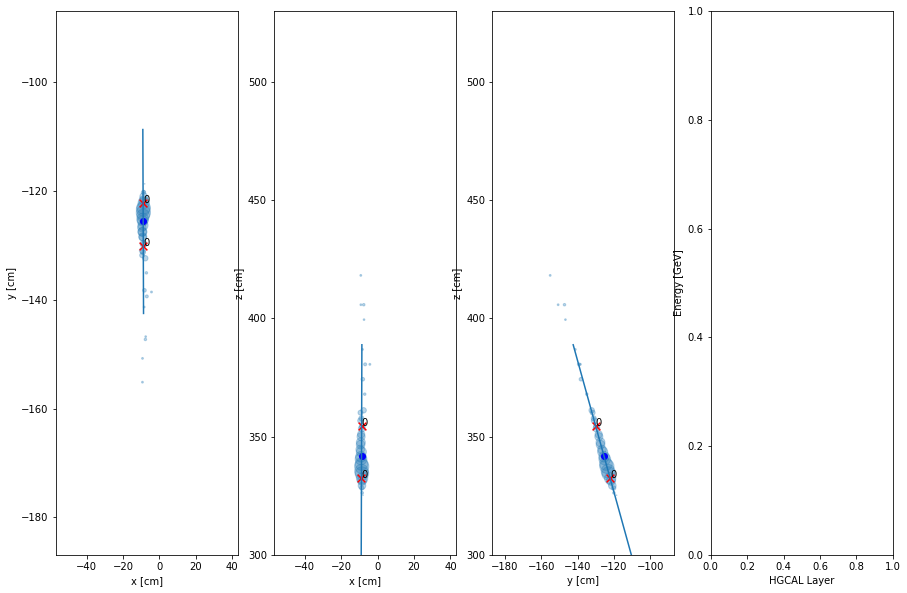

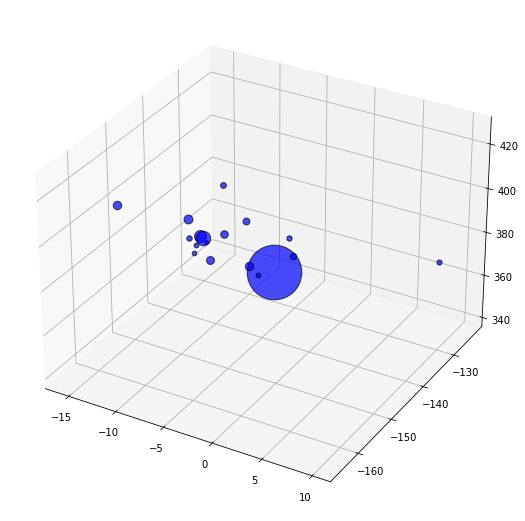

100%|██████████| 99/99 [38:10<00:00, 23.14s/it]


In [10]:
n_colors = 55
RGB_tuples = cm.winter(np.linspace(0, 1, n_colors))
RGB_tuples2 = cm.autumn(np.linspace(0, 1, n_colors))
iPlotInit = 0
maxPlot = 0
trackstersVecTot = []
#path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/PatatrackHackathon2023/CMSSW_13_X/CloseByPion0PU/histo/"
path = "/eos/cms/store/group/dpg_hgcal/comm_hgcal/wredjeb/PatatrackHackathon2023/CMSSW_13_X/CloseByTwoPions0PU/histo/"

files = glob.glob(path + "*.root")
for i_f, f in enumerate(tqdm(files[:-1])):
    fu = uproot.open(f)
    #     tmData = fu['ticlNtuplizer/trackstersMerged;1'].arrays(['barycenter_eta','barycenter_z', 'barycenter_phi', 'raw_energy'])
    #     assData = fu['ticlNtuplizer/associations;1'].arrays(['Mergetracksters_recoToSim_CP','Mergetracksters_recoToSim_CP_score','Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_sharedE', 'Mergetracksters_simToReco_CP_score'])
    #     lcs = fu['ticlNtuplizer/clusters;1'].arrays(['cluster_number_of_hits','energy'])
    #     simTSCP = fu['ticlNtuplizer/simtrackstersCP;1'].arrays(['stsCP_vertices_indexes','stsCP_vertices_multiplicity','stsCP_trackster_barycenter_eta', 'stsCP_trackster_barycenter_phi', 'stsCP_raw_pt', 'stsCP_raw_energy', 'stsCP_regressed_energy'])
    #     simTSSC = fu['ticlNtuplizer/simtrackstersSC;1'].arrays(['stsSC_trackster_barycenter_eta', 'stsSC_trackster_barycenter_phi', 'stsSC_regressed_energy', 'stsSC_raw_pt'])
    tmData = fu['ticlDumper/trackstersMerged;1'].arrays(['barycenter_eta','barycenter_z', 'barycenter_phi', 'raw_energy','vertices_indexes'])
    tracksters = fu['ticlDumper/tracksters;1'].arrays(['time', 'eVector0_x', 'eVector0_y', 'eVector0_z', 'trackster_barycenter_eta','trackster_barycenter_phi', 'raw_energy', 'vertices_indexes', 'barycenter_x', 'barycenter_y', 'barycenter_z'])
    candidates = fu['ticlDumper/candidates;1'].arrays(['tracksters_in_candidate'])
    assData = fu['ticlDumper/associations;1'].arrays(['tsCLUE3D_recoToSim_SC', 'tsCLUE3D_recoToSim_SC_score', 'tsCLUE3D_recoToSim_SC_sharedE', 'tsCLUE3D_simToReco_SC', 'tsCLUE3D_simToReco_SC_score', 
                                                      'tsCLUE3D_simToReco_SC_sharedE', 'tsCLUE3D_recoToSim_CP', 'tsCLUE3D_recoToSim_CP_score', 'tsCLUE3D_recoToSim_CP_sharedE', 'tsCLUE3D_simToReco_CP',
                                                      'tsCLUE3D_simToReco_CP_score', 'tsCLUE3D_simToReco_CP_sharedE',
                                                      'Mergetracksters_recoToSim_CP','Mergetracksters_recoToSim_CP_score','Mergetracksters_simToReco_CP', 'Mergetracksters_simToReco_CP_sharedE', 
                                                      'Mergetracksters_simToReco_CP_score'])
    try:            
        lcs = fu['ticlDumper/clusters;2'].arrays(['cluster_number_of_hits','energy', 'cluster_type', 'position_x', 'position_y', 'position_z', 'energy', 'cluster_layer_id'])
    except:
        lcs = fu['ticlDumper/clusters;1'].arrays(['cluster_number_of_hits','energy', 'cluster_type', 'position_x', 'position_y', 'position_z', 'energy', 'cluster_layer_id'])

    simTSCP = fu['ticlDumper/simtrackstersCP;1'].arrays(['vertices_indexes','vertices_multiplicity','trackster_barycenter_eta', 'trackster_barycenter_phi', 'raw_pt', 'raw_energy', 'regressed_energy'])
    simTSSC = fu['ticlDumper/simtrackstersSC;1'].arrays(['trackster_barycenter_eta', 'trackster_barycenter_phi', 'regressed_energy', 'raw_pt'])
    
    
    fractionEnergy = 0.1
    trackstersVecEvs = []
    for ev in range(len(tracksters)):
        
        tracksters_ev = tracksters[ev]
        bX_vis = tracksters_ev.barycenter_x
        bY_vis = tracksters_ev.barycenter_y
        bZ_vis = tracksters_ev.barycenter_z
        bE_vis = tracksters_ev.raw_energy
    
        lcs_ev = lcs[ev]
        
        if(iPlotInit <= maxPlot):
            fig = plt.figure(figsize=(15, 10))
    #         ax1 = fig.add_subplot(141, projection='3d')
            ax2 =fig.add_subplot(141)
            ax3 = fig.add_subplot(142)
            ax4 = fig.add_subplot(143)
            ax5 = fig.add_subplot(144)
            fig1 = plt.figure(figsize = (20,10))
            ax6 = fig1.add_subplot(121,projection = '3d')
            for x, y, z, e in zip(bX_vis, bY_vis, bZ_vis, bE_vis):
                ax6.scatter(x, y, z, s = 15*e, alpha=0.7, zorder=1, c='blue', edgecolors='k')
        
            

        trackstersVec = []
        for iT in range(len(tracksters_ev.raw_energy)):
            trackster_lcsInd = tracksters_ev.vertices_indexes[iT]
            lcs_x = lcs_ev.position_x[trackster_lcsInd]
            lcs_y = lcs_ev.position_y[trackster_lcsInd]
            lcs_z = lcs_ev.position_z[trackster_lcsInd]
            lcs_e = lcs_ev.energy[trackster_lcsInd]
            lcs_id = lcs_ev.cluster_layer_id[trackster_lcsInd]
            lcs_type = lcs_ev.cluster_type[trackster_lcsInd]
            
            if(len(lcs_x) > 0):
#             feats = np.stack((trackster_cluster_x,trackster_cluster_y,trackster_cluster_z, trackster_cluster_id,trackster_cluster_energy, trackster_cluster_type)).T
                #point_cloud = np.array(np.column_stack((lcs_x, lcs_y, lcs_z, lcs_id, lcs_e, lcs_type)))
                bX = tracksters_ev.barycenter_x[iT]
                bY = tracksters_ev.barycenter_y[iT]
                bZ = tracksters_ev.barycenter_z[iT]
                eX = tracksters_ev.eVector0_x[iT]
                eY = tracksters_ev.eVector0_y[iT]
                eZ = tracksters_ev.eVector0_z[iT]
                eTa = tracksters_ev.trackster_barycenter_eta[iT]
                ePhi = tracksters_ev.trackster_barycenter_phi[iT]

                pca_axis = [eX,eY,eZ]

                lcs_E = np.array([lcs_e, lcs_e,lcs_e])
                barycenter = [bX,bY,bZ]
                rawEnergy = tracksters_ev.raw_energy[iT]

                hgcal_layersZ = lcs_ev.position_z[trackster_lcsInd]
                hgcal_layerId = lcs_ev.cluster_layer_id[trackster_lcsInd]
                
                hgcal_uniqueLayerZ = np.zeros(50)
                
                 
                sumOverAllLayer = np.zeros(50)
                layerIds = np.arange(0,50, 1)
                
                for iLc, layerId in enumerate(hgcal_layerId):
                    sumOverAllLayer[layerId] += lcs_e[iLc]
                    hgcal_uniqueLayerZ[layerId] = hgcal_layersZ[iLc]
                    
                    
                firstLayerZ = sorted(hgcal_layersZ)[0]
                lastLayerZ = sorted(hgcal_layersZ)[-1]
                barycenter = [bX, bY,bZ]
                line_start = barycenter
#                 feats = np.stack((trackster_cluster_x,trackster_cluster_y,trackster_cluster_z, trackster_cluster_id,trackster_cluster_energy, trackster_cluster_type)).T
#                 origin, pca_axis, clean_arr = cleaningHAD(point_cloud,"eWeighted")
    
#                 point_cloud_for_ransac = point_cloud[:, :3]
#                 maxEnergy = max(point_cloud[:,4])
#                 weights = point_cloud[:,4] / maxEnergy              
#                 pca_axis, params_history, loss_history = fit_line_to_point_cloud(point_cloud_for_ransac, barycenter, weights = weights, delta = 2.0)
#                 origin, pca_axis, clean_arr = cleaningHAD(point_cloud,"eWeighted")
#                 pca_axis = [eX,eY,eZ]
                pca_axis = pca_axis / np.linalg.norm(pca_axis)
#                 print(f"Final residuals {residuals_final} direction {pca_axis}")

                t = np.linspace(-50, 50, 100)
                line_points = np.outer(t, pca_axis)
                
                # Extract coordinates from line points
                xDir = line_points[:, 0] + bX
                yDir = line_points[:, 1] + bY
                zDir = line_points[:, 2] + bZ
                
                ## sum LCs energy for each hgcal layers
                
                currentSum = 0.
                firstHGCalLayer = -1
                lastHGcalLayer = -1
                
                for iS, s in enumerate(sumOverAllLayer):
                    
                    currentSum += s 
#                     print(iS, currentSum, rawEnergy, currentSum / rawEnergy, firstHGCalLayer, lastHGcalLayer)
                    if(currentSum / rawEnergy >= fractionEnergy and firstHGCalLayer == -1):
                        firstHGCalLayer = iS
                    if(currentSum / rawEnergy >= 1 - fractionEnergy and lastHGcalLayer == -1):
                        lastHGcalLayer = iS

        #         ax1.set_xlabel("x (cm)")
        #         ax1.set_ylabel("y (cm)")
        #         ax1.set_zlabel("z (cm)")
                lcsOnFirstHGCalLayer = np.where(lcs_ev.cluster_layer_id == firstHGCalLayer)[0]
                maxEnergyLCsOnFirstLayer = np.argmax(lcs_ev.energy[lcsOnFirstHGCalLayer])
                indexLcMaxEnergyLCsOnFirstLayer = lcsOnFirstHGCalLayer[maxEnergyLCsOnFirstLayer]


                pointFirstLayer = intersect_line_with_surface(line_start, pca_axis, hgcal_uniqueLayerZ[firstHGCalLayer])
                pointLastLayer = intersect_line_with_surface(line_start, pca_axis, hgcal_uniqueLayerZ[lastHGcalLayer])
#                 print(firstHGCalLayer,lastHGcalLayer, pointFirstLayer, pointLastLayer)

                iTs = [iT for _ in range(len(lcs_x))]


                tracksterObj = Trackster(rawEnergy, barycenter, pointFirstLayer, pointLastLayer, pca_axis, lcs_x, lcs_y, lcs_z ,lcs_e, indexLcMaxEnergyLCsOnFirstLayer,eTa,ePhi)

                trackstersVec.append(tracksterObj)

                if(iPlotInit <= maxPlot):
                    iPlotInit += 1
                    alphaLC = 0.3
                    ax2.scatter(lcs_x, lcs_y, s = 10*np.array(lcs_e), alpha = alphaLC)
                    ax2.plot(xDir,yDir)
                    ax2.scatter(bX,bY, marker = 'o', c = 'b')
                    ms = 60

                    ax2.scatter(pointFirstLayer[0], pointFirstLayer[1], marker = 'x', c = RGB_tuples2[iTs][0], s = ms)
                    ax2.annotate(f"{iT}", (pointFirstLayer[0], pointFirstLayer[1]))
                    ax2.scatter(pointLastLayer[0], pointLastLayer[1], marker = 'x', c = RGB_tuples2[iTs][0], s = ms)
                    ax2.annotate(f"{iT}", (pointLastLayer[0], pointLastLayer[1]))
                    ax2.set_xlabel("x [cm]")
                    ax2.set_ylabel("y [cm]")
                    fixed_x_range = 100
                                    # Adjust the x-axis limits to achieve the desired range
                    x_center = (min(lcs_x) + max(lcs_x)) / 2  # Calculate the center of the x-axis range
                    y_center = (min(lcs_y) + max(lcs_y)) / 2  # Calculate the center of the x-axis range
                    z_center = (min(lcs_z) + max(lcs_z)) / 2
                    ax2.set_xlim(x_center - fixed_x_range/2, x_center + fixed_x_range/2)
                    ax2.set_ylim(y_center - fixed_x_range/2, y_center + fixed_x_range/2)

                    ax3.scatter(lcs_x, lcs_z, s = 10*np.array(lcs_e), alpha = alphaLC)
                    ax3.plot(xDir,zDir)
                    ax3.scatter(bX,bZ, marker = 'o', c = 'b')

                    ax3.scatter(pointFirstLayer[0], pointFirstLayer[2], marker = 'x', c = RGB_tuples2[iTs][0], s = ms)
                    ax3.annotate(f"{iT}", (pointFirstLayer[0], pointFirstLayer[2]))
                    ax3.scatter(pointLastLayer[0], pointLastLayer[2], marker = 'x', c =RGB_tuples2[iTs][0], s = ms)
                    ax3.annotate(f"{iT}", (pointLastLayer[0], pointLastLayer[2]))
                    ax3.set_xlabel("x [cm]")
                    ax3.set_ylabel("z [cm]")
                    ax3.set_xlim(x_center - fixed_x_range/2, x_center + fixed_x_range/2)
                    ax3.set_ylim(300, 530)

                    ax4.scatter(lcs_y, lcs_z, s = 10*np.array(lcs_e), alpha = alphaLC)
                    ax4.plot(yDir,zDir)
                    ax4.scatter(bY,bZ, marker = 'o', c = 'b')
                    ax4.scatter(pointFirstLayer[1], pointFirstLayer[2], marker = 'x', c = RGB_tuples2[iTs][0], s = ms)
                    ax4.annotate(f"{iT}", (pointFirstLayer[1], pointFirstLayer[2]))
                    ax4.scatter(pointLastLayer[1], pointLastLayer[2], marker = 'x', c =RGB_tuples2[iTs][0], s = ms)
                    ax4.annotate(f"{iT}", (pointLastLayer[1], pointLastLayer[2]))
                    ax4.set_xlabel("y [cm]")
                    ax4.set_ylabel("z [cm]")

                    ax4.set_xlim(y_center - fixed_x_range/2, y_center + fixed_x_range/2)
                    ax4.set_ylim(300, 530)
    #                     ax5.plot(np.arange(0, len(loss_history)), loss_history)

                    ax5.set_xlabel("HGCAL Layer")
                    ax5.set_ylabel("Energy [GeV]")
        plt.show()
                     
        trackstersVecEvs.append(trackstersVec)
    trackstersVecTot.append(trackstersVecEvs)
#         print(f"Tracksters in events {len(trackstersVec)}")
    

In [11]:
def calc_contam(sim_indices,frac,sim_idx,reco_indices):
        full_contam = 0
        for j in range(len(sim_indices)):
            if j != sim_idx:
                full_contam += ak.sum(frac[j][reco_indices])
        return full_contam

In [14]:
import math as m
%matplotlib widget
threshold = .8
delta = .2
eta_num_fill = []
energy_num_fill = []
pt_num_fill = [] 
phi_num_fill = []
eta_num_cont_fill = []
energy_num_cont_fill = []
pt_num_cont_fill = [] 
phi_num_cont_fill = []
eta_den_fill = []
energy_den_fill = []
pt_den_fill = [] 
phi_den_fill = []
angle = m.pi/16
points = []
edges_tot = []
contam_full = []
# angle = 0.33
edges_ev = []
n_colors = 30
deviation_threshold = .2
RGB_tuples = cm.winter(np.linspace(0, 1, n_colors))
RGB = cm.autumn(np.linspace(0, 1, n_colors))
iPlot = 0
maxPlot = 0
vertex = [0,0,0]
# for f in range(len(trackstersVecTot)):    
for f in tqdm(range(len(trackstersVecTot))):
# for f in range(1):
#     for ev in range(30):

    for ev in range(len(trackstersVecTot[f])):
#         print(ev)
        simToRecoCP_indices = ass_data_tot[f].tsCLUE3D_simToReco_CP[ev]
        simToRecoCP_sharedFraction = ass_data_tot[f].tsCLUE3D_simToReco_CP_sharedE[ev]
        simToRecoCP_score = ass_data_tot[f].tsCLUE3D_simToReco_CP_score[ev]
        sim_energy = simtrackstersCP_data_tot[f].raw_energy[ev]
        sim_pt = simtrackstersCP_data_tot[f].raw_pt[ev]
        sim_phi = simtrackstersCP_data_tot[f].trackster_barycenter_phi[ev]
        sim_eta = simtrackstersCP_data_tot[f].trackster_barycenter_eta[ev]
        reco_energy = trk_data_tot[f].raw_energy[ev]
        reco_pt = trk_data_tot[f].raw_pt[ev]
        reco_phi = trk_data_tot[f].trackster_barycenter_phi[ev]
        reco_eta = trk_data_tot[f].trackster_barycenter_eta[ev]    
        lcs_ev = lcs[ev]
        if(iPlot <= maxPlot):
            fig = plt.figure(figsize=(15, 15))
            ax1 = fig.add_subplot(111, projection='3d')

            ax1.set_xlabel("x (cm)")
            ax1.set_ylabel("y (cm)")
            ax1.set_zlabel("z (cm)")
        edges = []
        edges_ticl = []
        trackstersVec = trackstersVecTot[f][ev]
        ordered_data = sorted(trackstersVec, key=lambda t : t.barycenter[2])
        
        for iT, trackster in enumerate(ordered_data):

            lastPoint = trackster.p1
            firstPoint = trackster.p0
            barycenter = trackster.barycenter
            eta = trackster.eta
            phi = trackster.phi
            angle = np.deg2rad(20)
            angle2 = np.deg2rad(20)
            base_radius = np.tan(angle) * (np.linalg.norm(lastPoint - firstPoint))
            base_radius2 = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
            angle_diff = np.arccos(np.dot(trackster.eigenvector,(np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))))
            if(iPlot<=maxPlot):
                print(angle_diff)
            if angle_diff>deviation_threshold:
                eigenvector = (np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))
            else:
                eigenvector = trackster.eigenvector
            x,y,z = trackster.barycenter

            h = np.linalg.norm(lastPoint - firstPoint)
            latestPoint = intersect_line_with_surface(line_start, eigenvector,500)
            h2 = np.linalg.norm(latestPoint - lastPoint)

            for iT2, trackster2 in enumerate(ordered_data):
                if(iT2 != iT):
                    xp,yp,zp = trackster2.p0
                    x,y,z = trackster.p0
                    eta = trackster.eta
                    etap = trackster2.eta
                    phi = trackster.phi
                    phip = trackster2.phi
                    sep = np.sqrt((eta-etap)**2+(phi-phip)**2)
                    if sep<delta:
                        edges_ticl.append([iT,iT2])
                    
                    if check_point_cone(h,base_radius,angle,firstPoint,xp,yp,zp,eigenvector) or check_point_cone(h2,base_radius2,angle2,lastPoint,xp,yp,zp,eigenvector):
                        edges.append([iT,iT2])
                        if(iPlot <= maxPlot):
                            ax1.plot([xp, x], [yp, y], [zp, z], c='blue', alpha=0.4)

            
            if(iPlot <= maxPlot):
                print(angle_diff)
                iPlot += 1
                #create vertex point
                indexLC = trackster.indexLC
    #                 start_point = [lcs_ev.position_x[trackster.indexLC], lcs_ev.position_y[indexLC], lcs_ev.position_z[indexLC]]
                start_point = trackster.p0
                #define direction of trackster barycenter and normalize
                eigenvector = trackster.eigenvector
                eigenvector /= np.linalg.norm(eigenvector)
                #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
                not_ev = np.array([1, 0, 0])

                if (eigenvector == not_ev).all():
                    not_ev = np.array([0, 1, 0])
                if(eigenvector[2] < 0):
                    eigenvector = -eigenvector
                #create orthogonal vector 1
                ev_cross = np.cross(eigenvector, not_ev)
                #create orthogonal vector 2
                ev_cross /= np.linalg.norm(ev_cross)
                ev_cross2 = np.abs(np.cross(eigenvector, ev_cross))

                t = np.linspace(0, h , 100)
                theta = np.linspace(0, 2 * np.pi, 100)

                line_points = [start_point + ti * eigenvector for ti in t]
        #         base_radius = np.tan(angle) * (np.linalg.norm(line_points[-1] - start_point))
                line_points = np.array(line_points)
                cone_dist = np.dot(line_points - start_point, eigenvector)
                R = (cone_dist / h) * base_radius
                tp, theta = np.meshgrid(t, theta)
                # Plot the cone surface
        #         print(start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2])
        #         print(f"start point {start_point}, evec {eigenvector} R {R} sintheta {np.sin(theta)} costheta {np.cos(theta)} ev_corss {ev_cross} ev_cross2 {ev_cross2}")
                X, Y, Z = (
                    start_point[0] + eigenvector[0] * tp + R * np.sin(theta) * ev_cross[0] + R * np.cos(theta) * ev_cross2[0],
                    start_point[1] + eigenvector[1] * tp + R * np.sin(theta) * ev_cross[1] + R * np.cos(theta) * ev_cross2[1],
                    start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2],
                )

    #                 print(f"Eigenvector {eigenvector} ")
                t = np.linspace(-50, 50, 100)
                line_points = np.outer(t, eigenvector)
                bX,bY,bZ = trackster.barycenter

                # Extract coordinates from line points
                xDir = line_points[:, 0] + bX
                yDir = line_points[:, 1] + bY
                zDir = line_points[:, 2] + bZ
                ax1.plot_surface(X, Y, Z, alpha=0.05)
        #             ax1.plot(xDir, yDir, zDir)
    #                 ax1.scatter(trackster.lcx, trackster.lcy,trackster.lcz, s = 20*trackster.lce, alpha = 0.4)
                xFP, yFP, zFP = trackster.p0
                ax1.scatter(xFP, yFP, zFP)

                start_point = trackster.p1
                #define direction of trackster barycenter and normalize
                eigenvector = trackster.eigenvector
                eigenvector /= np.linalg.norm(eigenvector)
                #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
                not_ev = np.array([1, 0, 0])

                if (eigenvector == not_ev).all():
                    not_ev = np.array([0, 1, 0])
                if(eigenvector[2] < 0):
                    eigenvector = -eigenvector
                #create orthogonal vector 1
                ev_cross = np.cross(eigenvector, not_ev)
                #create orthogonal vector 2
                ev_cross /= np.linalg.norm(ev_cross)
                ev_cross2 = np.abs(np.cross(eigenvector, ev_cross))

                t = np.linspace(0, 100 , 100)
                theta = np.linspace(0, 2 * np.pi, 100)

                line_points = [start_point + ti * eigenvector for ti in t]
        #         base_radius = np.tan(angle) * (np.linalg.norm(line_points[-1] - start_point))
                base_radius = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
                line_points = np.array(line_points)
                cone_dist = np.dot(line_points - start_point, eigenvector)
                R = (cone_dist / h) * base_radius
                tp, theta = np.meshgrid(t, theta)
                # Plot the cone surface
        #         print(start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2])
        #         print(f"start point {start_point}, evec {eigenvector} R {R} sintheta {np.sin(theta)} costheta {np.cos(theta)} ev_corss {ev_cross} ev_cross2 {ev_cross2}")
                X, Y, Z = (
                    start_point[0] + eigenvector[0] * tp + R * np.sin(theta) * ev_cross[0] + R * np.cos(theta) * ev_cross2[0],
                    start_point[1] + eigenvector[1] * tp + R * np.sin(theta) * ev_cross[1] + R * np.cos(theta) * ev_cross2[1],
                    start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2],
                )

                    # Rest of your code...

                ax1.plot_surface(X, Y, Z, alpha=0.05)
                ax1.set_title(f"Top view: Trackster cones from PCA axis ({angle}) radians")
                ax1.view_init(0,180)
                fixed_x_range = 100
                x_center = (min(trackster.lcx) + max(trackster.lcx)) / 2  # Calculate the center of the x-axis range
                y_center = (min(trackster.lcy) + max(trackster.lcy)) / 2  # Calculate the center of the x-axis range
                z_center = (min(trackster.lcz) + max(trackster.lcz)) / 2
                ax1.set_xlim(x_center - fixed_x_range/2, x_center + fixed_x_range/2)
                ax1.set_ylim(y_center - fixed_x_range/2, y_center + fixed_x_range/2)

                ax1.set_box_aspect([1, 1, 1])

        #         set_axes_equal(ax1)
                ax1.get_yaxis().set_ticks([])
                ax1.get_yaxis().set_visible(False)
        plt.show()
        connected_edges = connected_components(order_pairs(edges))
        connected_edges_ticl = connected_components(order_pairs(edges_ticl))
        #for each simtrackster in the event
        reco_trk_energies = []
        reco_trk_indices = []
        efficiencies = []
        sim_track_energies = []
        sim_numerator = []
        sim_denominator = []
        sim_numerator_contam = []
        for sim_idx,e in enumerate(range(len(simToRecoCP_indices))):
            isMatched = False
            sim_track_energies.append(sim_energy[e])
            if(connected_edges):                
                for r in range(len(connected_edges)):
                    indexesConnectedEdges = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                    contamination_index = [x for x in connected_edges[r] if x not in indexesConnectedEdges]
                    reco_trk_energies.append(np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges]))
                    denEnergy = ak.sum(simToRecoCP_sharedFraction[e])
                    efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
                    contamination = calc_contam(simToRecoCP_indices,simToRecoCP_sharedFraction,sim_idx,indexesConnectedEdges)/(denEnergy+10**(-10))
                    contam_full.append(contamination)
#                     print(f"Number of Tracksters {len(reco_energy)} Event {ev} connected_edges {connected_edges} eff {efficiency} sim energy {denEnergy} reco energy {np.sum(simToRecoCP_sharedFraction[0][connected_edges[r]])}")
                    if efficiency>threshold:
                        isMatched= True
                        sim_numerator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                        eta_num_fill.append(sim_eta[e])
                        phi_num_fill.append(sim_phi[e])
                        energy_num_fill.append(sim_energy[e])
                        pt_num_fill.append(sim_pt[e])
                        if contamination>.2:
                            sim_numerator_contam.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                            eta_num_cont_fill.append(sim_eta[e])
                            phi_num_cont_fill.append(sim_phi[e])
                            energy_num_cont_fill.append(sim_energy[e])
                            pt_num_cont_fill.append(sim_pt[e])
                        break
            sim_denominator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
            eta_den_fill.append(sim_denominator[e][3])
            phi_den_fill.append(sim_denominator[e][2])
            energy_den_fill.append(sim_denominator[e][0])
            pt_den_fill.append(sim_denominator[e][1])
            '''
            if(connected_edges_ticl):                
                for r in range(len(connected_edges_ticl)):
                    indexesConnectedEdges = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                    contamination_index = [x for x in connected_edges[r] if x not in indexesConnectedEdges]
                    reco_trk_energies.append(np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges]))
                    denEnergy = ak.sum(simToRecoCP_sharedFraction[e])
                    efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
                    contamination = calc_contam(simToRecoCP_indices,simToRecoCP_sharedFraction,sim_idx,indexesConnectedEdges)/(denEnergy+10**(-10))
                    contam_full.append(contamination)
#                     print(f"Number of Tracksters {len(reco_energy)} Event {ev} connected_edges {connected_edges} eff {efficiency} sim energy {denEnergy} reco energy {np.sum(simToRecoCP_sharedFraction[0][connected_edges[r]])}")
                    if efficiency>threshold:
                        isMatched= True
                        sim_numerator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                        eta_num_fill.append(sim_eta[e])
                        phi_num_fill.append(sim_phi[e])
                        energy_num_fill.append(sim_energy[e])
                        pt_num_fill.append(sim_pt[e])
                        if contamination>.2:
                            sim_numerator_contam.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                            eta_num_cont_fill.append(sim_eta[e])
                            phi_num_cont_fill.append(sim_phi[e])
                            energy_num_cont_fill.append(sim_energy[e])
                            pt_num_cont_fill.append(sim_pt[e])
                        break
            sim_denominator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
            eta_den_fill.append(sim_denominator[e][3])
            phi_den_fill.append(sim_denominator[e][2])
            energy_den_fill.append(sim_denominator[e][0])
            pt_den_fill.append(sim_denominator[e][1])
            '''

        
#         plt.savefig(f'visualization_plot/vis_cleanedPCA{ev}')
        edges_ev.append(edges)


  0%|          | 0/99 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.02910541043809784
0.02910541043809784


/tmp/ipykernel_400/2222000639.py:232: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
  5%|▌         | 5/99 [00:20<06:34,  4.20s/it]/tmp/ipykernel_400/3653906924.py:99: RuntimeWarning: invalid value encountered in double_scalars
  cone_r = (cone_dist/h)*base_radius_computed
100%|██████████| 99/99 [06:15<00:00,  3.79s/it]


In [15]:
NBINS = 10
NBINSPT = 10
NBINSPHI = 10
NBINSETA = 10
e_N, bins_e = np.histogram(energy_num_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
e_D, bins_e = np.histogram(energy_den_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
pt_N, bins_pt = np.histogram(pt_num_fill, bins = NBINSPT, range = (0,200))
pt_D, bins_pt = np.histogram(pt_den_fill, bins = NBINSPT, range = (0, 200))
phi_N, bins_phi = np.histogram(phi_num_fill, bins = NBINSPHI, range = (min(phi_den_fill),max(phi_den_fill)))
phi_D, bins_phi = np.histogram(phi_den_fill, bins = NBINSPHI, range = (min(phi_den_fill), max(phi_den_fill)))
eta_N, bins_eta = np.histogram(eta_num_fill, bins = NBINSETA, range = (min(eta_den_fill),max(eta_den_fill)))
eta_D, bins_eta = np.histogram(eta_den_fill, bins = NBINSETA, range = (min(eta_den_fill), max(eta_den_fill)))

ratioE, stdE = computeRatio(e_N,e_D)
#errorsE = fixError(ratioE, bin_errorsE)
ratioPt, stdPt = computeRatio(pt_N,pt_D)
#errorsPt = fixError(ratioPt, bin_errorsPt)
ratioEta, stdEta = computeRatio(eta_N,eta_D)
#errorsEta = fixError(ratioEta, bin_errorsEta)
ratioPhi, stdPhi = computeRatio(phi_N,phi_D)
#errorsPhi = fixError(ratioPhi, bin_errorsPhi)


/tmp/ipykernel_400/3653906924.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = df1/ df2
/tmp/ipykernel_400/3653906924.py:117: RuntimeWarning: invalid value encountered in true_divide
  ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))


In [16]:
NBINS = 10
NBINSPT = 10
NBINSPHI = 10
NBINSETA = 10
e_N_cont, bins_e = np.histogram(energy_num_cont_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
e_D, bins_e = np.histogram(energy_den_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
pt_N_cont, bins_pt = np.histogram(pt_num_cont_fill, bins = NBINSPT, range = (0,200))
pt_D, bins_pt = np.histogram(pt_den_fill, bins = NBINSPT, range = (0, 200))
phi_N_cont, bins_phi = np.histogram(phi_num_cont_fill, bins = NBINSPHI, range = (min(phi_den_fill),max(phi_den_fill)))
phi_D, bins_phi = np.histogram(phi_den_fill, bins = NBINSPHI, range = (min(phi_den_fill), max(phi_den_fill)))
eta_N_cont, bins_eta = np.histogram(eta_num_cont_fill, bins = NBINSETA, range = (min(eta_den_fill),max(eta_den_fill)))
eta_D, bins_eta = np.histogram(eta_den_fill, bins = NBINSETA, range = (min(eta_den_fill), max(eta_den_fill)))

ratioEc, stdEc = computeRatio(e_N_cont,e_D)
#errorsE = fixError(ratioE, bin_errorsE)
ratioPtc, stdPtc = computeRatio(pt_N_cont,pt_D)
#errorsPt = fixError(ratioPt, bin_errorsPt)
ratioEtac, stdEtac = computeRatio(eta_N_cont,eta_D)
#errorsEta = fixError(ratioEta, bin_errorsEta)
ratioPhic, stdPhic = computeRatio(phi_N_cont,phi_D)
#errorsPhi = fixError(ratioPhi, bin_errorsPhi)


/tmp/ipykernel_400/3653906924.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = df1/ df2
/tmp/ipykernel_400/3653906924.py:117: RuntimeWarning: invalid value encountered in true_divide
  ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))


In [17]:
plt.figure(figsize = (40,10))
i_c = 0
col = 'blue'
Particle = "Pion"
PU = 0
c = .5
number = 'double'
plt.subplot(1,4,1)
plt.errorbar(bins_e[:-1], ratioE, yerr=stdE, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c =  col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen Energy [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')

plt.subplot(1,4,2)
plt.errorbar(bins_pt[:-1], ratioPt, yerr=stdPt, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $p_{T}$ [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.xlim(None, np.max(200))
plt.subplot(1,4,3)
plt.errorbar(bins_phi[:-1], ratioPhi, yerr=stdPhi, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $\phi$")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number} {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.subplot(1,4,4)
plt.errorbar(bins_eta[:-1], ratioEta, yerr=stdEta, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TICLv4 - Efficiency ")
    plt.xlabel("gen $\eta$")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.5, 3]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [18]:
plt.figure(figsize = (40,10))
i_c = 0
col = 'blue'
Particle = "Pion"
PU = 0
c = .5
plt.subplot(1,4,1)
plt.errorbar(bins_e[:-1], ratioEc, yerr=stdEc, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c =  col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen Energy [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')

plt.subplot(1,4,2)
plt.errorbar(bins_pt[:-1], ratioPtc, yerr=stdPtc, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $p_{T}$ [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.xlim(None, np.max(200))
plt.subplot(1,4,3)
plt.errorbar(bins_phi[:-1], ratioPhic, yerr=stdPhic, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $\phi$")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.subplot(1,4,4)
plt.errorbar(bins_eta[:-1], ratioEtac, yerr=stdEtac, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TICLv4 - Efficiency ")
    plt.xlabel("gen $\eta$")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.5, 3]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))
    
def order_pairs(pairs):
    sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
    return sorted_pair

                  eta_den_fill: 169.0 KiB
               energy_den_fill: 169.0 KiB
                   pt_den_fill: 169.0 KiB
                  phi_den_fill: 169.0 KiB
                   contam_full: 169.0 KiB
                  eta_num_fill: 150.1 KiB
               energy_num_fill: 150.1 KiB
                   pt_num_fill: 150.1 KiB
                  phi_num_fill: 150.1 KiB
             eta_num_cont_fill: 118.6 KiB


In [20]:
# class GraphFitnessEvaluator:
#     def __init__(self, tracksters,f,ev,ass_data,):
        
#         self.f = f
#         self.ev = ev
#         self.trackstersVec = tracksters[self.f][self.ev]
#         self.simToRecoCP_indices = ass_data_tot[self.f].tsCLUE3D_simToReco_CP[self.ev]
#         self.simToRecoCP_sharedFraction = ass_data_tot[self.f].tsCLUE3D_simToReco_CP_sharedE[self.ev]
#         self.simToRecoCP_score = ass_data_tot[self.f].tsCLUE3D_simToReco_CP_score[self.ev]
#         self.sim_energy = simtrackstersCP_data_tot[self.f].raw_energy[self.ev]
#         sim_pt = simtrackstersCP_data_tot[self.f].raw_pt[self.ev]
#         sim_phi = simtrackstersCP_data_tot[self.f].trackster_barycenter_phi[self.ev]
#         sim_eta = simtrackstersCP_data_tot[self.f].trackster_barycenter_eta[self.ev]
#     def build_graph(self,particle_pos):
        
#         ordered_data = sorted(self.trackstersVec, key=lambda t : t.barycenter[2])
#         edges = []

#         for iT, trackster in enumerate(ordered_data):
#             lastPoint = trackster.p1
#             firstPoint = trackster.p0
#             barycenter = trackster.barycenter
#             angle = np.deg2rad(20)
#             angle2 = np.deg2rad(20)
#             base_radius = np.tan(angle) * (np.linalg.norm(lastPoint - firstPoint))
#             base_radius2 = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
#             angle_diff = np.arccos(np.dot(trackster.eigenvector,(np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))))
#             if(iPlot<=maxPlot):
#                 print(angle_diff)
#             if angle_diff>deviation_threshold:
#                 eigenvector = (np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))
#             else:
#                 eigenvector = trackster.eigenvector
#             x,y,z = trackster.barycenter

#             h = np.linalg.norm(lastPoint - firstPoint)
#             latestPoint = intersect_line_with_surface(line_start, eigenvector,500)
#             h2 = np.linalg.norm(latestPoint - lastPoint)

#             for iT2, trackster2 in enumerate(ordered_data):
#                 if(iT2 != iT):
#                     xp,yp,zp = trackster2.p0
#                     x,y,z = trackster.p0
#                     if self.check_point_cone(h,base_radius,particle_pos[0],firstPoint,xp,yp,zp,eigenvector) or self.check_point_cone(h2,base_radius2,particle_pos[2],[x,y,z],xp,yp,zp,eigenvector):
#                         edges.append([iT,iT2])
#                         if(iPlot <= maxPlot):
#                             ax1.plot([xp, x], [yp, y], [zp, z], c='blue', alpha=0.4)
#         self.connected_edges = self.connected_components(self.order_pairs(edges))
#         return self.connected_edges
#     def connected_components(self,pairs):
#         components = []

#         for a, b in pairs:
#             for component in components:
#                 if a in component:
#                     for i, other_component in enumerate(components):
#                         if b in other_component and other_component != component: 
#                             component.extend(other_component)
#                             components[i:i+1] = []
#                             break 
#                     else: 
#                         if b not in component:
#                             component.append(b)
#                     break 
#                 if b in component: 
#                     component.append(a)
#                     break 
#             else: 
#     #             if components:
#     #                 if a or b in component:
#     #                     break
#     #             else:
#                 components.append([a, b])
#         return components
#     def order_pairs(self,pairs):
#         sorted_pairs = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
#         return sorted_pairs

#     def check_point_cone(self,h,base_radius,angle,start_point,x,y,z,eigenvector):
#         test_point = np.array([x,y,z])
#         base_radius_computed = np.tan(angle)*h
#         cone_dist = np.dot(test_point-start_point,eigenvector)
#         if cone_dist < 0 or cone_dist > h:
#             # The test point is outside the length of the cone
#             return False
#         cone_r = (cone_dist/h)*base_radius_computed
#         dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
#         return dist<cone_r
#     def evaluate(self,efficiency_weight,contam_weight):
#         self.efficiency_weight = efficiency_weight
#         self.contamination_weight = contam_weight
#         highest_efficiency = 0.
#         lowest_contam = 0
#         sim_high_eff = 0
#         high_contam_index = 0
#         high_denEnergy = 0.
#         highest_contam = 0.
#         for e in range(len(self.simToRecoCP_indices)):
            
#             isMatched = False
#             if(self.connected_edges):                
#                 for r in range(len(self.connected_edges)):
#                     indexesConnectedEdges = [list(self.simToRecoCP_indices[e]).index(b) for b in self.connected_edges[r]]
#                     contamination_index = [x for x in self.connected_edges[r] if x not in indexesConnectedEdges]
#                     #print(contamination_index)
#                     denEnergy = ak.sum(self.simToRecoCP_sharedFraction[e])
#                     if denEnergy <=.0005:
#                         denEnergy = sim_energy[e]
                    
#                     efficiency = np.sum(self.simToRecoCP_sharedFraction[e][self.connected_edges[r]])/denEnergy
#                     contamination = np.sum(self.simToRecoCP_sharedFraction[e][contamination_index])/denEnergy
#                     #print("EFF",np.sum(self.simToRecoCP_sharedFraction[e][self.connected_edges[r]]),denEnergy,"CONT",contamination)
#                     #    
#                     if(efficiency>highest_efficiency):
#                         highest_efficiency = efficiency
#                         sim_high_eff = e
                        
#                        # print("DENENERGY",denEnergy)
#                         #print("NO")
#                         if contamination>highest_contam:
#                             #print("yes")
#                             high_contam_index = contamination_index
                            
#         contamination_full = 0
#         #print(high_contam_index)
#         for j in range(len(self.simToRecoCP_indices)):
#             #print(np.sum(self.simToRecoCP_sharedFraction[j][high_contam_index]))
#             if j != sim_high_eff:
#                 if high_contam_index ==0:
#                     continue
#                 else:
#                     if ak.sum(self.simToRecoCP_sharedFraction[j]) ==0.:
#                         continue
#                     else:
#                         contamination_full = np.sum(self.simToRecoCP_sharedFraction[j][high_contam_index])/ak.sum(self.simToRecoCP_sharedFraction[j])
#                    # print(ak.sum(self.simToRecoCP_sharedFraction[j]))
        
        

#         return 1-highest_efficiency,contamination_full

In [ ]:
#lloop over connectd compoments thats well associated with simtrackster
# if there is a well associated reco-trackster, move on to other simtrackster
#second metric duplicate rate
#find best associated
#inspect that components, see the contamination, .2 should be the thre

In [ ]:
ass_data_tot[0].tsCLUE3D_simToReco_CP

In [ ]:
simToRecoCP_sharedFraction[0]

In [21]:
#create graph object where, given the number of files you want to evaluate, along with your thresholds for efficient and contaminated tracksters, 
#you are able to efficiently evaluate

class GraphFitnessEvaluator1:
    def __init__(self, tracksters,num_f,ass_data,eff_thr,cont_thr):
        self.eff_thr = eff_thr
        self.cont_thr = cont_thr
        self.num_f = num_f
        #self.ev = ev
       
        self.trackstersVecTot = tracksters
       
    def build_graph(self,particle_pos):
        efficiency_global, contamination_global = [],[]
        cont_num = 0
        eff_num = 0
        den = 0
        fake_num = 0
        fake_den = 0
        high_efficiency = 0
        for f in tqdm(range(self.num_f)):
            sim_pt = simtrackstersCP_data_tot[f].raw_pt
            sim_phi = simtrackstersCP_data_tot[f].trackster_barycenter_phi
            sim_eta = simtrackstersCP_data_tot[f].trackster_barycenter_eta
            for en in range(len(trackstersVecTot[f])):  
               # print(en)

                simToRecoCP_indices = ass_data_tot[f].tsCLUE3D_simToReco_CP[en]
                simToRecoCP_sharedFraction = ass_data_tot[f].tsCLUE3D_simToReco_CP_sharedE[en]
                simToRecoCP_score = ass_data_tot[f].tsCLUE3D_simToReco_CP_score[en]
                sim_energy = simtrackstersCP_data_tot[f].raw_energy[en]
                sim_pt = simtrackstersCP_data_tot[f].raw_pt[en]
                sim_phi = simtrackstersCP_data_tot[f].trackster_barycenter_phi[en]
                sim_eta = simtrackstersCP_data_tot[f].trackster_barycenter_eta[en]
                reco_energy = trk_data_tot[f].raw_energy[en]
                reco_pt = trk_data_tot[f].raw_pt[en]
                reco_phi = trk_data_tot[f].trackster_barycenter_phi[en]
                reco_eta = trk_data_tot[f].trackster_barycenter_eta[en]        
                lcs_ev = lcs[en]
                edges = []
                high_contam_index = []
                sim_high_eff = 0
                trackstersVec = trackstersVecTot[f][en]
                ordered_data = sorted(trackstersVec, key=lambda t : t.barycenter[2])
                for iT, trackster in enumerate(ordered_data):
                    lastPoint = trackster.p1
                    firstPoint = trackster.p0
                    barycenter = trackster.barycenter

                    angle = np.deg2rad(20)
                    angle2 = np.deg2rad(20)
                    base_radius = np.tan(angle) * (np.linalg.norm(lastPoint - firstPoint))
                    base_radius2 = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
                    angle_diff = np.arccos(np.dot(trackster.eigenvector,(np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))))
                    if(iPlot<=maxPlot):
                        print(angle_diff)
                    if angle_diff>deviation_threshold:
                        eigenvector = (np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))
                    else:
                        eigenvector = trackster.eigenvector
                    x,y,z = trackster.barycenter

                    h = np.linalg.norm(lastPoint - firstPoint)
                    latestPoint = intersect_line_with_surface(line_start, eigenvector,500)
                    h2 = np.linalg.norm(latestPoint - lastPoint)
                    for iT2, trackster2 in enumerate(ordered_data):
                        if(iT2 != iT):
                            xp,yp,zp = trackster2.p0
                            x,y,z = trackster.p0
                            if self.check_point_cone(h,base_radius,particle_pos[0],firstPoint,xp,yp,zp,eigenvector) or self.check_point_cone(particle_pos[1],base_radius2,particle_pos[2],lastPoint,xp,yp,zp,eigenvector):
                                edges.append([iT,iT2])

                connected_edges = np.array(self.connected_components(self.order_pairs(edges)))
                #print("pre",connected_edges)
                #for each simtrackster in the event

                for sim_idx,e in enumerate(range(len(simToRecoCP_indices))):
                    isMatched = False
                    sim_track_energies.append(sim_energy[e])
                    if(connected_edges.all() !=0):                
                        for r in range(len(connected_edges)):
                            #print(connected_edges[r])
                            #print(simToRecoCP_indices[e])
                           # print(connected_edges[r])
                            #print(list(simToRecoCP_indices[e]))
                            indexesConnectedEdges = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                            #contamination_index = [x for x in connected_edges[r] if x not in indexesConnectedEdges]
                            denEnergy = ak.sum(simToRecoCP_sharedFraction[e])
                            if denEnergy <=.0005:
                                denEnergy = sim_energy[e]
                            efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/(denEnergy+10**(-10))
                            contamination = self.calc_contam(simToRecoCP_indices,simToRecoCP_sharedFraction,sim_idx,indexesConnectedEdges)/(denEnergy+10**(-10))

                           # print(efficiency)
                            if(efficiency>self.eff_thr):
                                #print("pass")
                                #print(efficiency)
                                eff_num +=1
                                high_efficiency = efficiency
                                if contamination>self.cont_thr:
                                    cont_num +=1

                            else:
                                fake_num +=1

                            break
                        fake_den+=1
                    den+=1

                 
        return np.array([1-eff_num/den,fake_num/fake_den])
    def calc_contam(self,sim_indices,frac,sim_idx,reco_indices):
        full_contam = 0
        for j in range(len(sim_indices)):
            if j != sim_idx:
                full_contam += ak.sum(frac[j][reco_indices])
        return full_contam
    def connected_components(self,pairs):
        components = []

        for a, b in pairs:
            for component in components:
                if a in component:
                    for i, other_component in enumerate(components):
                        if b in other_component and other_component != component: 
                            component.extend(other_component)
                            components[i:i+1] = []
                            break 
                    else: 
                        if b not in component:
                            component.append(b)
                    break 
                if b in component: 
                    component.append(a)
                    break 
            else: 
    #             if components:
    #                 if a or b in component:
    #                     break
    #             else:
                components.append([a, b])
        return components
    def order_pairs(self,pairs):
        sorted_pair = sorted(pairs, key=lambda pair: (pair[1], pair[0]))
        return sorted_pair

    def check_point_cone(self,h,base_radius,angle,start_point,x,y,z,eigenvector):
        test_point = np.array([x,y,z])
        base_radius_computed = np.tan(angle)*h
        cone_dist = np.dot(test_point-start_point,eigenvector)
        if cone_dist < 0 or cone_dist > h:
            # The test point is outside the length of the cone
            return False
        cone_r = (cone_dist/h)*base_radius_computed
        dist = np.linalg.norm((test_point-start_point)-cone_dist*eigenvector)
        return dist<cone_r
    def graph_target(self,x):
        

        return self.build_graph(x)


In [26]:

num_f = 3
ef_thr = .7
cont_thr = .2

G_f = GraphFitnessEvaluator1(trackstersVecTot,num_f,ass_data_tot,ef_thr,cont_thr).graph_target

In [33]:
NParam = 2
PB = np.asarray([[0, np.pi/10],[0,20],[0,np.pi/10]])
Optimizer = mo.MOBayesianOpt(target=G_f,
                             NObj=2,
                             pbounds=PB,max_or_min = 'min',RandomSeed=12345)

In [34]:
Optimizer = mo.MOBayesianOpt(target=G_f,
                             NObj=2,
                             pbounds=PB,max_or_min = 'min')

In [35]:
Optimizer.initialize(init_points=6)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_400/2119848568.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))
100%|██████████| 3/3 [00:05<00:00,  1.81s/it]


In [40]:
front, pop = Optimizer.maximize(n_iter=10)

  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_400/2119848568.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))
  0%|          | 0/3 [00:00<?, ?it/s]/tmp/ipykernel_400/2119848568.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))
100%|██████████| 3/3 [00:06<00:00,  2.23s/it]
/cvmfs/sft.cern.ch/lcg/views/LCG_102b_cuda/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/sklearn/gaussian_

In [39]:
f1 = np.linspace(0, 1, 1000)
f2 = (1-np.sqrt(f1))
fig, ax = plt.subplots(1, 1)
#ax.plot(f1, f2, '-', label="TPF")
ax.scatter(front[:, 0], front[:, 1], label=r"$\chi$")
ax.grid()
ax.set_xlabel(r'$1-efficiency$')
ax.set_ylabel(r'$contamination$')
ax.set_title("Bayesian pareto front")
ax.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
np.savetxt("front.csv", front, delimiter=",")
np.savetxt("pop.csv",pop,delimiter = ",")


In [158]:
import math as m
p_front = 10
%matplotlib widget
threshold = .7
eta_num_fill = []
energy_num_fill = []
pt_num_fill = [] 
phi_num_fill = []
eta_num_cont_fill = []
energy_num_cont_fill = []
pt_num_cont_fill = [] 
phi_num_cont_fill = []
eta_den_fill = []
energy_den_fill = []
pt_den_fill = [] 
phi_den_fill = []
angle = m.pi/16
points = []
edges_tot = []
contam_full = []
# angle = 0.33
edges_ev = []
n_colors = 30
deviation_threshold = .2
RGB_tuples = cm.winter(np.linspace(0, 1, n_colors))
RGB = cm.autumn(np.linspace(0, 1, n_colors))
iPlot = 0
maxPlot = 0
vertex = [0,0,0]
# for f in range(len(trackstersVecTot)):    
for f in tqdm(range(len(trackstersVecTot))):
# for f in range(1):
#     for ev in range(30):

    for ev in range(len(trackstersVecTot[f])):
#         print(ev)
        simToRecoCP_indices = ass_data_tot[f].tsCLUE3D_simToReco_CP[ev]
        simToRecoCP_sharedFraction = ass_data_tot[f].tsCLUE3D_simToReco_CP_sharedE[ev]
        simToRecoCP_score = ass_data_tot[f].tsCLUE3D_simToReco_CP_score[ev]
        sim_energy = simtrackstersCP_data_tot[f].raw_energy[ev]
        sim_pt = simtrackstersCP_data_tot[f].raw_pt[ev]
        sim_phi = simtrackstersCP_data_tot[f].trackster_barycenter_phi[ev]
        sim_eta = simtrackstersCP_data_tot[f].trackster_barycenter_eta[ev]
        reco_energy = trk_data_tot[f].raw_energy[ev]
        reco_pt = trk_data_tot[f].raw_pt[ev]
        reco_phi = trk_data_tot[f].trackster_barycenter_phi[ev]
        reco_eta = trk_data_tot[f].trackster_barycenter_eta[ev]    
        lcs_ev = lcs[ev]
        if(iPlot <= maxPlot):
            fig = plt.figure(figsize=(15, 15))
            ax1 = fig.add_subplot(111, projection='3d')

            ax1.set_xlabel("x (cm)")
            ax1.set_ylabel("y (cm)")
            ax1.set_zlabel("z (cm)")
        edges = []
        edges_ticl = []
        trackstersVec = trackstersVecTot[f][ev]
        ordered_data = sorted(trackstersVec, key=lambda t : t.barycenter[2])
        
        for iT, trackster in enumerate(ordered_data):

            lastPoint = trackster.p1
            firstPoint = trackster.p0
            barycenter = trackster.barycenter
           # eta = trackster.eta
            #phi = trackster.phi
            angle = np.deg2rad(20)
            angle2 = np.deg2rad(20)
            base_radius = np.tan(angle) * (np.linalg.norm(lastPoint - firstPoint))
            base_radius2 = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
            angle_diff = np.arccos(np.dot(trackster.eigenvector,(np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))))
            if(iPlot<=maxPlot):
                print(angle_diff)
            if angle_diff>deviation_threshold:
                eigenvector = (np.array(trackster.barycenter)-np.array(vertex))/np.linalg.norm(np.array(trackster.barycenter)-np.array(vertex))
            else:
                eigenvector = trackster.eigenvector
            x,y,z = trackster.barycenter

            h = np.linalg.norm(lastPoint - firstPoint)
            latestPoint = intersect_line_with_surface(line_start, eigenvector,500)
            h2 = np.linalg.norm(latestPoint - lastPoint)

            for iT2, trackster2 in enumerate(ordered_data):
                if(iT2 != iT):
                    xp,yp,zp = trackster2.p0
                    x,y,z = trackster.p0
#                     eta = trackster.eta
#                     etap = trackster2.eta
#                     phi = trackster.phi
#                     phip = trackster2.phi
#                     sep = np.sqrt((eta-etap)**2+(phi-phip)**2)
#                     if sep<delta:
#                         edges_ticl.append([iT,iT2])
                    
                    if check_point_cone(h,base_radius,pop[p_front][0],firstPoint,xp,yp,zp,eigenvector) or check_point_cone(pop[p_front][1],base_radius2,pop[p_front][2],lastPoint,xp,yp,zp,eigenvector):
                        edges.append([iT,iT2])
                        if(iPlot <= maxPlot):
                            ax1.plot([xp, x], [yp, y], [zp, z], c='blue', alpha=0.4)

            
            if(iPlot <= maxPlot):
                print(angle_diff)
                iPlot += 1
                #create vertex point
                indexLC = trackster.indexLC
    #                 start_point = [lcs_ev.position_x[trackster.indexLC], lcs_ev.position_y[indexLC], lcs_ev.position_z[indexLC]]
                start_point = trackster.p0
                #define direction of trackster barycenter and normalize
                eigenvector = trackster.eigenvector
                eigenvector /= np.linalg.norm(eigenvector)
                #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
                not_ev = np.array([1, 0, 0])

                if (eigenvector == not_ev).all():
                    not_ev = np.array([0, 1, 0])
                if(eigenvector[2] < 0):
                    eigenvector = -eigenvector
                #create orthogonal vector 1
                ev_cross = np.cross(eigenvector, not_ev)
                #create orthogonal vector 2
                ev_cross /= np.linalg.norm(ev_cross)
                ev_cross2 = np.abs(np.cross(eigenvector, ev_cross))

                t = np.linspace(0, h , 100)
                theta = np.linspace(0, 2 * np.pi, 100)

                line_points = [start_point + ti * eigenvector for ti in t]
        #         base_radius = np.tan(angle) * (np.linalg.norm(line_points[-1] - start_point))
                line_points = np.array(line_points)
                cone_dist = np.dot(line_points - start_point, eigenvector)
                R = (cone_dist / h) * base_radius
                tp, theta = np.meshgrid(t, theta)
                # Plot the cone surface
        #         print(start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2])
        #         print(f"start point {start_point}, evec {eigenvector} R {R} sintheta {np.sin(theta)} costheta {np.cos(theta)} ev_corss {ev_cross} ev_cross2 {ev_cross2}")
                X, Y, Z = (
                    start_point[0] + eigenvector[0] * tp + R * np.sin(theta) * ev_cross[0] + R * np.cos(theta) * ev_cross2[0],
                    start_point[1] + eigenvector[1] * tp + R * np.sin(theta) * ev_cross[1] + R * np.cos(theta) * ev_cross2[1],
                    start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2],
                )

    #                 print(f"Eigenvector {eigenvector} ")
                t = np.linspace(-50, 50, 100)
                line_points = np.outer(t, eigenvector)
                bX,bY,bZ = trackster.barycenter

                # Extract coordinates from line points
                xDir = line_points[:, 0] + bX
                yDir = line_points[:, 1] + bY
                zDir = line_points[:, 2] + bZ
                ax1.plot_surface(X, Y, Z, alpha=0.05)
        #             ax1.plot(xDir, yDir, zDir)
    #                 ax1.scatter(trackster.lcx, trackster.lcy,trackster.lcz, s = 20*trackster.lce, alpha = 0.4)
                xFP, yFP, zFP = trackster.p0
                ax1.scatter(xFP, yFP, zFP)

                start_point = trackster.p1
                #define direction of trackster barycenter and normalize
                eigenvector = trackster.eigenvector
                eigenvector /= np.linalg.norm(eigenvector)
                #create arbitrary vector not in same direction as eigenvector in order to create orthogonal vector
                not_ev = np.array([1, 0, 0])

                if (eigenvector == not_ev).all():
                    not_ev = np.array([0, 1, 0])
                if(eigenvector[2] < 0):
                    eigenvector = -eigenvector
                #create orthogonal vector 1
                ev_cross = np.cross(eigenvector, not_ev)
                #create orthogonal vector 2
                ev_cross /= np.linalg.norm(ev_cross)
                ev_cross2 = np.abs(np.cross(eigenvector, ev_cross))

                t = np.linspace(0, 100 , 100)
                theta = np.linspace(0, 2 * np.pi, 100)

                line_points = [start_point + ti * eigenvector for ti in t]
        #         base_radius = np.tan(angle) * (np.linalg.norm(line_points[-1] - start_point))
                base_radius = np.tan(angle2) * (np.linalg.norm(lastPoint - firstPoint))
                line_points = np.array(line_points)
                cone_dist = np.dot(line_points - start_point, eigenvector)
                R = (cone_dist / h) * base_radius
                tp, theta = np.meshgrid(t, theta)
                # Plot the cone surface
        #         print(start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2])
        #         print(f"start point {start_point}, evec {eigenvector} R {R} sintheta {np.sin(theta)} costheta {np.cos(theta)} ev_corss {ev_cross} ev_cross2 {ev_cross2}")
                X, Y, Z = (
                    start_point[0] + eigenvector[0] * tp + R * np.sin(theta) * ev_cross[0] + R * np.cos(theta) * ev_cross2[0],
                    start_point[1] + eigenvector[1] * tp + R * np.sin(theta) * ev_cross[1] + R * np.cos(theta) * ev_cross2[1],
                    start_point[2] + eigenvector[2] * tp + R * np.sin(theta) * ev_cross[2] + R * np.cos(theta) * ev_cross2[2],
                )

                    # Rest of your code...

                ax1.plot_surface(X, Y, Z, alpha=0.05)
                ax1.set_title(f"Top view: Trackster cones from PCA axis ({angle}) radians")
                ax1.view_init(0,180)
                fixed_x_range = 100
                x_center = (min(trackster.lcx) + max(trackster.lcx)) / 2  # Calculate the center of the x-axis range
                y_center = (min(trackster.lcy) + max(trackster.lcy)) / 2  # Calculate the center of the x-axis range
                z_center = (min(trackster.lcz) + max(trackster.lcz)) / 2
                ax1.set_xlim(x_center - fixed_x_range/2, x_center + fixed_x_range/2)
                ax1.set_ylim(y_center - fixed_x_range/2, y_center + fixed_x_range/2)

                ax1.set_box_aspect([1, 1, 1])

        #         set_axes_equal(ax1)
                ax1.get_yaxis().set_ticks([])
                ax1.get_yaxis().set_visible(False)
        plt.show()
        connected_edges = connected_components(order_pairs(edges))
        connected_edges_ticl = connected_components(order_pairs(edges_ticl))
        #for each simtrackster in the event
        reco_trk_energies = []
        reco_trk_indices = []
        efficiencies = []
        sim_track_energies = []
        sim_numerator = []
        sim_denominator = []
        sim_numerator_contam = []
        for sim_idx,e in enumerate(range(len(simToRecoCP_indices))):
            isMatched = False
            sim_track_energies.append(sim_energy[e])
            if(connected_edges):                
                for r in range(len(connected_edges)):
                    indexesConnectedEdges = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                    contamination_index = [x for x in connected_edges[r] if x not in indexesConnectedEdges]
                    reco_trk_energies.append(np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges]))
                    denEnergy = ak.sum(simToRecoCP_sharedFraction[e])
                    efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
                    contamination = calc_contam(simToRecoCP_indices,simToRecoCP_sharedFraction,sim_idx,indexesConnectedEdges)/(denEnergy+10**(-10))
                    contam_full.append(contamination)
#                     print(f"Number of Tracksters {len(reco_energy)} Event {ev} connected_edges {connected_edges} eff {efficiency} sim energy {denEnergy} reco energy {np.sum(simToRecoCP_sharedFraction[0][connected_edges[r]])}")
                    if efficiency>threshold:
                        isMatched= True
                        sim_numerator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                        eta_num_fill.append(sim_eta[e])
                        phi_num_fill.append(sim_phi[e])
                        energy_num_fill.append(sim_energy[e])
                        pt_num_fill.append(sim_pt[e])
                        if contamination>.2:
                            sim_numerator_contam.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                            eta_num_cont_fill.append(sim_eta[e])
                            phi_num_cont_fill.append(sim_phi[e])
                            energy_num_cont_fill.append(sim_energy[e])
                            pt_num_cont_fill.append(sim_pt[e])
                        break
            sim_denominator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
            eta_den_fill.append(sim_denominator[e][3])
            phi_den_fill.append(sim_denominator[e][2])
            energy_den_fill.append(sim_denominator[e][0])
            pt_den_fill.append(sim_denominator[e][1])
            '''
            if(connected_edges_ticl):                
                for r in range(len(connected_edges_ticl)):
                    indexesConnectedEdges = [list(simToRecoCP_indices[e]).index(b) for b in connected_edges[r]]
                    contamination_index = [x for x in connected_edges[r] if x not in indexesConnectedEdges]
                    reco_trk_energies.append(np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges]))
                    denEnergy = ak.sum(simToRecoCP_sharedFraction[e])
                    efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
                    contamination = calc_contam(simToRecoCP_indices,simToRecoCP_sharedFraction,sim_idx,indexesConnectedEdges)/(denEnergy+10**(-10))
                    contam_full.append(contamination)
#                     print(f"Number of Tracksters {len(reco_energy)} Event {ev} connected_edges {connected_edges} eff {efficiency} sim energy {denEnergy} reco energy {np.sum(simToRecoCP_sharedFraction[0][connected_edges[r]])}")
                    if efficiency>threshold:
                        isMatched= True
                        sim_numerator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                        eta_num_fill.append(sim_eta[e])
                        phi_num_fill.append(sim_phi[e])
                        energy_num_fill.append(sim_energy[e])
                        pt_num_fill.append(sim_pt[e])
                        if contamination>.2:
                            sim_numerator_contam.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
                            eta_num_cont_fill.append(sim_eta[e])
                            phi_num_cont_fill.append(sim_phi[e])
                            energy_num_cont_fill.append(sim_energy[e])
                            pt_num_cont_fill.append(sim_pt[e])
                        break
            sim_denominator.append([sim_energy[e],sim_pt[e],sim_phi[e],sim_eta[e]])
            eta_den_fill.append(sim_denominator[e][3])
            phi_den_fill.append(sim_denominator[e][2])
            energy_den_fill.append(sim_denominator[e][0])
            pt_den_fill.append(sim_denominator[e][1])
            '''

        
#         plt.savefig(f'visualization_plot/vis_cleanedPCA{ev}')
        edges_ev.append(edges)


  0%|          | 0/99 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

0.02910541043809784
0.02910541043809784


  1%|          | 1/99 [00:02<04:36,  2.82s/it]/tmp/ipykernel_400/51934384.py:232: RuntimeWarning: invalid value encountered in double_scalars
  efficiency = np.sum(simToRecoCP_sharedFraction[e][indexesConnectedEdges])/denEnergy
  5%|▌         | 5/99 [00:12<04:00,  2.56s/it]/tmp/ipykernel_400/3653906924.py:99: RuntimeWarning: invalid value encountered in double_scalars
  cone_r = (cone_dist/h)*base_radius_computed
100%|██████████| 99/99 [04:10<00:00,  2.53s/it]


In [167]:
graph_target(pop[p_front],len(trk_data_tot),.7,.2)

  0%|          | 0/99 [00:00<?, ?it/s]/tmp/ipykernel_400/2716741562.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))
  5%|▌         | 5/99 [00:09<03:05,  1.97s/it]/tmp/ipykernel_400/2716741562.py:151: RuntimeWarning: invalid value encountered in double_scalars
  cone_r = (cone_dist/h)*base_radius_computed
100%|██████████| 99/99 [03:09<00:00,  1.92s/it]


array([0.11304593, 0.4028596 ])

In [160]:
coedges_ev[1]

[[1, 20], [3, 21], [10, 23], [12, 30]]

In [105]:
NBINS = 10
NBINSPT = 10
NBINSPHI = 10
NBINSETA = 10
e_N, bins_e = np.histogram(energy_num_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
e_D, bins_e = np.histogram(energy_den_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
pt_N, bins_pt = np.histogram(pt_num_fill, bins = NBINSPT, range = (0,200))
pt_D, bins_pt = np.histogram(pt_den_fill, bins = NBINSPT, range = (0, 200))
phi_N, bins_phi = np.histogram(phi_num_fill, bins = NBINSPHI, range = (min(phi_den_fill),max(phi_den_fill)))
phi_D, bins_phi = np.histogram(phi_den_fill, bins = NBINSPHI, range = (min(phi_den_fill), max(phi_den_fill)))
eta_N, bins_eta = np.histogram(eta_num_fill, bins = NBINSETA, range = (min(eta_den_fill),max(eta_den_fill)))
eta_D, bins_eta = np.histogram(eta_den_fill, bins = NBINSETA, range = (min(eta_den_fill), max(eta_den_fill)))

ratioE, stdE = computeRatio(e_N,e_D)
#errorsE = fixError(ratioE, bin_errorsE)
ratioPt, stdPt = computeRatio(pt_N,pt_D)
#errorsPt = fixError(ratioPt, bin_errorsPt)
ratioEta, stdEta = computeRatio(eta_N,eta_D)
#errorsEta = fixError(ratioEta, bin_errorsEta)
ratioPhi, stdPhi = computeRatio(phi_N,phi_D)
#errorsPhi = fixError(ratioPhi, bin_errorsPhi)


/tmp/ipykernel_400/3653906924.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = df1/ df2
/tmp/ipykernel_400/3653906924.py:117: RuntimeWarning: invalid value encountered in true_divide
  ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))


In [106]:
NBINS = 10
NBINSPT = 10
NBINSPHI = 10
NBINSETA = 10
e_N_cont, bins_e = np.histogram(energy_num_cont_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
e_D, bins_e = np.histogram(energy_den_fill, bins = NBINS, range = (min(energy_den_fill), max(energy_den_fill)))
pt_N_cont, bins_pt = np.histogram(pt_num_cont_fill, bins = NBINSPT, range = (0,200))
pt_D, bins_pt = np.histogram(pt_den_fill, bins = NBINSPT, range = (0, 200))
phi_N_cont, bins_phi = np.histogram(phi_num_cont_fill, bins = NBINSPHI, range = (min(phi_den_fill),max(phi_den_fill)))
phi_D, bins_phi = np.histogram(phi_den_fill, bins = NBINSPHI, range = (min(phi_den_fill), max(phi_den_fill)))
eta_N_cont, bins_eta = np.histogram(eta_num_cont_fill, bins = NBINSETA, range = (min(eta_den_fill),max(eta_den_fill)))
eta_D, bins_eta = np.histogram(eta_den_fill, bins = NBINSETA, range = (min(eta_den_fill), max(eta_den_fill)))

ratioEc, stdEc = computeRatio(e_N_cont,e_D)
#errorsE = fixError(ratioE, bin_errorsE)
ratioPtc, stdPtc = computeRatio(pt_N_cont,pt_D)
#errorsPt = fixError(ratioPt, bin_errorsPt)
ratioEtac, stdEtac = computeRatio(eta_N_cont,eta_D)
#errorsEta = fixError(ratioEta, bin_errorsEta)
ratioPhic, stdPhic = computeRatio(phi_N_cont,phi_D)
#errorsPhi = fixError(ratioPhi, bin_errorsPhi)


/tmp/ipykernel_400/3653906924.py:116: RuntimeWarning: invalid value encountered in true_divide
  ratio = df1/ df2
/tmp/ipykernel_400/3653906924.py:117: RuntimeWarning: invalid value encountered in true_divide
  ratio_st = np.nan_to_num(np.sqrt((np.sqrt(df1)/df1)**2 + (np.sqrt(df2)/df2)**2))


In [107]:
plt.figure(figsize = (40,10))
i_c = 0
col = 'blue'
Particle = "Pion"
PU = 0
c = .5
number = 'double'
plt.subplot(1,4,1)
plt.errorbar(bins_e[:-1], ratioE, yerr=stdE, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c =  col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen Energy [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')

plt.subplot(1,4,2)
plt.errorbar(bins_pt[:-1], ratioPt, yerr=stdPt, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $p_{T}$ [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.xlim(None, np.max(200))
plt.subplot(1,4,3)
plt.errorbar(bins_phi[:-1], ratioPhi, yerr=stdPhi, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $\phi$")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number} {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.subplot(1,4,4)
plt.errorbar(bins_eta[:-1], ratioEta, yerr=stdEta, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TICLv4 - Efficiency ")
    plt.xlabel("gen $\eta$")
    plt.ylabel("Efficiency")
    plt.annotate(f"{number}  {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.5, 3]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
plt.figure(figsize = (40,10))
i_c = 0
col = 'blue'
Particle = "Pion"
PU = 0
c = .5
plt.subplot(1,4,1)
plt.errorbar(bins_e[:-1], ratioEc, yerr=stdEc, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c =  col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen Energy [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')

plt.subplot(1,4,2)
plt.errorbar(bins_pt[:-1], ratioPtc, yerr=stdPtc, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $p_{T}$ [GeV]")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.xlim(None, np.max(200))
plt.subplot(1,4,3)
plt.errorbar(bins_phi[:-1], ratioPhic, yerr=stdPhic, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TracksterMerge - Efficiency ")
    plt.xlabel("gen $\phi$")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.7, 2.7]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')
plt.subplot(1,4,4)
plt.errorbar(bins_eta[:-1], ratioEtac, yerr=stdEtac, linestyle = None, marker = 'o', lw = 1, label = f"Shared Fraction Threshold {c}", capsize = 2, c = col, markersize = 8)
# plt.errorbar(bins_e3[:-1], ratioE3, yerr=stdE3, linestyle = None, marker = 'o', lw = 1, label = 'TICLv3', capsize = 2)
plt.ylim(0,1.05)
if(i_c == 0):
    plt.suptitle("TICLv4 - Efficiency ")
    plt.xlabel("gen $\eta$")
    plt.ylabel("Efficiency")
    plt.annotate(f"Single {Particle} {PU} PU\nE $\in$ [10,600]\n$\eta$ $\in$ [1.5, 3]", xy = (0.4,0.4), xycoords='axes fraction')
    #hep.cms.text('Simulation')


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [62]:
arr

array([[2.60769716e-04, 1.83807914e-01, 3.00000000e+00],
       [5.35451272e-04, 1.43169558e-01, 4.00000000e+00],
       [1.00014726e-03, 1.30553133e-01, 6.00000000e+00],
       [1.30711046e-03, 1.30553133e-01, 7.00000000e+00],
       [1.89268412e-03, 2.55004497e-01, 2.30000000e+01],
       [2.72598935e-03, 1.33573032e-01, 5.00000000e+01],
       [4.61008379e-03, 2.15650243e-01, 5.20000000e+01],
       [1.19625598e-02, 2.38753453e-01, 5.80000000e+01],
       [1.93311530e-02, 2.02221800e-01, 6.10000000e+01],
       [2.06670999e-02, 1.31067511e-01, 6.30000000e+01],
       [3.36653624e-02, 1.32349470e-01, 6.80000000e+01],
       [3.51813261e-02, 1.33215018e-01, 8.10000000e+01],
       [4.95276162e-02, 1.92520711e-01, 8.20000000e+01],
       [5.19984351e-02, 1.32482144e-01, 8.40000000e+01],
       [5.19984351e-02, 2.23548435e-01, 9.60000000e+01]])

In [385]:
#PSO, Doesn't work for me, also too slow with having to evaluate graph for 100s of particles


class Particle:

    def __init__(self, lower_bound=-10, upper_bound=10, num_objectives=2):
        self.position = np.random.uniform(lower_bound, upper_bound)
        self.num_objectives = num_objectives
        self.velocity = np.zeros_like(self.position)
        self.best_position = self.position
        self.best_fitness = np.array([10 for i in range(num_objectives)])  # inf for minimization
        self.fitness = np.array([np.inf,np.inf])
#         self.best_fitness = np.ones(self.num_objectives)
#         self.fitness = np.ones(self.num_objectives)

    def update_velocity(self,
                        global_best_position, inertia_weight=0.5,
                        cognitive_coefficient=1, social_coefficient=1):
        """
        Update the particle's velocity based on its best position and the global best position.

        Parameters:
            global_best_position (numpy.ndarray): Global best position in the swarm.
            inertia_weight (float): Inertia weight controlling the impact of the previous velocity
                                    (default is 0.5).
            cognitive_coefficient (float): Cognitive coefficient controlling the impact of personal
                                           best (default is 1).
            social_coefficient (float): Social coefficient controlling the impact of global best
                            
                            (default is 1).
        """
        #print("before",self.velocity)
        #print("self_position",self.position)
        cognitive_random = np.random.uniform(0, 1)
        social_random = np.random.uniform(0, 1)
        #print(cognitive_random,social_random, "pos",  cognitive_random * (self.best_position - self.position),"pso+dif",(self.best_position - self.position))
        #print("best",self.best_position,"reg",self.position)
        cognitive = cognitive_coefficient*cognitive_random*(self.best_position - self.position)
        social = social_coefficient * social_random*(global_best_position - self.position)
       # print("social",social)
        self.velocity = inertia_weight * self.velocity + cognitive + social
       # print("after",self.velocity)
    def update_position(self, lower_bound, upper_bound):
        """
        Update the particle's position based on its current velocity and bounds.

        Parameters:
            lower_bound (numpy.ndarray): Lower bound for the particle's position.
            upper_bound (numpy.ndarray): Upper bound for the particle's position.
        """
        #print("before",self.position)
        self.position = np.clip(self.position + self.velocity, lower_bound, upper_bound)
        #print("after",self.position)

    def set_fitness(self, fitness):
        """
        Set the fitness values of the particle and calls `update_best` method to update the
        particle's fitness and best position.

        Parameters:
            fitness (numpy.ndarray): The fitness values of the particle for each objective.
        """
        self.fitness = np.array(fitness)
        self.update_best()

    def evaluate_fitness(self, objective_functions):
        """
        Evaluate the fitness of the particle based on the provided objective functions.
        Calls the `set_fitness` method to update the particle's fitness and best position.

        Parameters:
            objective_functions (list): List of objective functions used for fitness evaluation.
        """
        fitness = [objective_functions[0].build_graph(self.position)[0],objective_functions[0].build_graph(self.position)[1]]
        self.set_fitness(fitness)

    def update_best(self):
        """
        Update particle's fitness and best position
        """
        if np.any(self.best_fitness == np.zeros(self.num_objectives)):
            self.fitness = np.ones(self.num_objectives)
        if np.all(self.fitness < self.best_fitness):
            self.best_fitness = self.fitness
            self.best_position = self.position


class MOPSO:
   

    def __init__(self, objective_functions, lower_bound, upper_bound, num_particles=50,
        intertia_weight=0.5, cognitive_coefficient=1, social_coefficient=1,
        num_iterations=100,
        optimization_mode='individual',
        max_iter_no_improv=None,
        num_objectives=None):
        self.objective_functions = objective_functions
        if num_objectives is None:
            self.num_objectives = len(self.objective_functions)
        else:
            self.num_objectives = num_objectives
        self.num_particles = num_particles
        self.lower_bounds = lower_bound
        self.upper_bounds = upper_bound
        self.inertia_weight = intertia_weight
        self.cognitive_coefficient = cognitive_coefficient
        self.social_coefficient = social_coefficient
        self.num_iterations = num_iterations
        self.max_iter_no_improv = max_iter_no_improv
        self.optimization_mode = optimization_mode
        self.particles = [Particle(lower_bound, upper_bound, self.num_objectives)
                          for _ in range(num_particles)]
        self.global_best_position = np.zeros_like(lower_bound)
        self.global_best_fitness = [np.inf] * self.num_objectives
        self.history = []

    def optimize(self):
        
        for _ in range(self.num_iterations):
            if self.optimization_mode == 'global':
                optimization_output = [objective_function.build_graph([particle.position for
                                                           particle in self.particles])
                                       for objective_function in self.objective_functions]
            for p_id, particle in enumerate(self.particles):
                if self.optimization_mode == 'individual':
                    particle.evaluate_fitness(self.objective_functions)
                if self.optimization_mode == 'global':
                    particle.set_fitness([output[p_id]
                                         for output in optimization_output])
                if np.all(particle.fitness < self.global_best_fitness):
                    self.global_best_fitness = particle.fitness
                    self.global_best_position = particle.position

                particle.update_best()
               # print("particle_POS", particle.best_position, particle.best_fitness)
                self.update_global_best()

                particle.update_velocity(self.global_best_position,
                                         self.inertia_weight,
                                         self.cognitive_coefficient,
                                         self.social_coefficient)
                particle.update_position(self.lower_bounds, self.upper_bounds)

            self.history.append(self.global_best_fitness)

        pareto_front = self.get_pareto_front()
        return pareto_front

    def update_global_best(self):
        """
        Update the global best position and fitness based on the swarm's particles.
        """
        for particle in self.particles:
            if np.all(particle.fitness <= self.global_best_fitness):
                self.global_best_fitness = particle.fitness
                self.global_best_position = particle.position

    def get_pareto_front(self):
        """
        Get the Pareto front of non-dominated solutions.

        Returns:
            list: List of Particle objects representing the Pareto front.
        """
        pareto_front = []
        for particle in self.particles:
            dominated = False
            for other_particle in self.particles:
                if np.all(particle.fitness >= other_particle.fitness) and \
                   np.any(particle.fitness > other_particle.fitness):
                    dominated = True
                    break
            if not dominated:
                pareto_front.append(particle)
        # Sort the Pareto front by crowding distance
        crowding_distances = self.calculate_crowding_distance(pareto_front)
        pareto_front.sort(key=lambda x: crowding_distances[x], reverse=True)
        return pareto_front

    def calculate_crowding_distance(self, pareto_front):
        """
        Calculate the crowding distance for particles in the Pareto front.

        Parameters:
            pareto_front (list): List of Particle objects representing the Pareto front.

        Returns:
            dict: A dictionary with Particle objects as keys and their corresponding crowding
                  distances as values.
        """
        crowding_distances = {particle: 0 for particle in pareto_front}
        for objective_index in range(self.num_objectives):
            # Sort the Pareto front by the current objective function
            pareto_front_sorted = sorted(pareto_front, key=lambda x, i=objective_index: x.fitness[i])
            crowding_distances[pareto_front_sorted[0]] = np.inf
            crowding_distances[pareto_front_sorted[-1]] = np.inf
            for i in range(1, len(pareto_front_sorted)-1):
                crowding_distances[pareto_front_sorted[i]] += (pareto_front_sorted[i+1].fitness[objective_index] -pareto_front_sorted[i-1].fitness[objective_index])

        return crowding_distances

In [386]:
class TestEval:
    def __init__(self,func):
        self.func = func
    def build_graph(self,particle_pos):
        
        return 1-particle_pos[0]/self.func[0]+self.func[1],particle_pos[1]/self.func[1]+self.func[0]

In [387]:
Graph_fit1.build_graph([.2,10,.1])

/tmp/ipykernel_399/2605767920.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))


(0.0860779601073628, 0.7927461139896373)

In [389]:
#lb = [.1,2,.1] #!!!
#ub = [np.pi/15,10,np.pi/15] #!!!
lb = [0,0]
ub = [3,4]
# create the PSO object
pso = MOPSO([Graph_fit1],
                 [0.001,0.001,.001], [np.pi/10,10,np.pi/10], num_particles=3,
                 intertia_weight=0.5, cognitive_coefficient=1, social_coefficient=1,
                 num_iterations=10,
                 optimization_mode='individual',
                 max_iter_no_improv=3,
                 num_objectives=2)

# run the optimization algorithm
pareto_front = pso.optimize()

# print the results
print("Global best position:", pso.global_best_position)
print("Global best fitness:", pso.global_best_fitness[0],pso.global_best_fitness[1])

# plot the Pareto front
fig1 = plt.figure(figsize=(15, 10))
pareto_x = [particle.fitness[0] for particle in pareto_front]
print(pareto_x)
pareto_y = [particle.fitness[1] for particle in pareto_front]
plt.scatter(pareto_x, pareto_y)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Front")
plt.savefig("pareto")

# plot the convergence history
plt.plot(pso.history)
plt.xlabel("Iteration")
plt.ylabel("Global Best Fitness")
plt.title("Convergence History")
plt.savefig("convergence")

particle_POS [0.02779773 1.10491282 0.14854306] [1.         0.01005025]
self_position [0.02779773 1.10491282 0.14854306]
best [0.02779773 1.10491282 0.14854306] reg [0.02779773 1.10491282 0.14854306]
before [0.02779773 1.10491282 0.14854306]
after [0.02779773 1.10491282 0.14854306]


/tmp/ipykernel_399/2605767920.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))


particle_POS [0.1423304  7.80214153 0.09888984] [0.07128027 0.68783069]
self_position [0.1423304  7.80214153 0.09888984]
best [0.1423304  7.80214153 0.09888984] reg [0.1423304  7.80214153 0.09888984]
before [0.1423304  7.80214153 0.09888984]
after [0.04997883 2.40193928 0.13892691]
particle_POS [0.07032666 1.26592747 0.18107099] [1.         0.11055276]
self_position [0.07032666 1.26592747 0.18107099]
best [0.07032666 1.26592747 0.18107099] reg [0.07032666 1.26592747 0.18107099]
before [0.07032666 1.26592747 0.18107099]
after [0.06373348 1.24096569 0.17602825]
particle_POS [0.02779773 1.10491282 0.14854306] [1.         0.01005025]
self_position [0.02779773 1.10491282 0.14854306]
best [0.02779773 1.10491282 0.14854306] reg [0.02779773 1.10491282 0.14854306]
before [0.02779773 1.10491282 0.14854306]
after [0.02779773 1.10491282 0.14854306]
particle_POS [0.1423304  7.80214153 0.09888984] [0.07128027 0.68783069]
self_position [0.04997883 2.40193928 0.13892691]
best [0.1423304  7.80214153 0.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[1.0]


In [352]:
pso.global_best_fitness

array([1.])

In [264]:
graph_builder = GraphFitnessEvaluator1(trackstersVecTot,1,ass_data_tot,100,.7,0.)

In [265]:
graph_builder.build_graph([.1,200,0])

/tmp/ipykernel_399/1143468645.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  connected_edges = np.array(self.connected_components(self.order_pairs(edges)))


(0.07128027332503906, 0.32663316582914576)

In [257]:
test = TestEval([2,1])

In [262]:
#lb = [.1,2,.1] #!!!
#ub = [np.pi/15,10,np.pi/15] #!!!
lb = [0,0]
ub = [3,4]
# create the PSO object
pso = MOPSO(objective_functions=[test], 
        lb=lb, ub=ub, num_particles=100, num_iterations=10, w=.5, 
        c1=.1, c2=2, max_iter_no_improv=3)

# run the optimization algorithm
pareto_front = pso.optimize()

# print the results
print("Global best position:", pso.global_best_position)
print("Global best fitness:", pso.global_best_fitness[0],pso.global_best_fitness[1])

# plot the Pareto front
fig1 = plt.figure(figsize=(15, 10))
pareto_x = [particle.fitness[0] for particle in pareto_front]
print(pareto_x)
pareto_y = [particle.fitness[1] for particle in pareto_front]
plt.scatter(pareto_x, pareto_y)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Pareto Front")
plt.savefig("pareto")

# plot the convergence history
plt.plot(pso.history)
plt.xlabel("Iteration")
plt.ylabel("Global Best Fitness")
plt.title("Convergence History")
plt.savefig("convergence")

 10%|█         | 1/10 [00:00<00:01,  6.89it/s]

passoptimize
glo_fitness [-0.27955156  2.94288518]
update_particle [-0.27955156  2.94288518] best [-0.27955156  2.94288518]
passupdate_global
vel_update [0. 0.]
pos_update [2.55910312 2.94288518]
update_particle [-0.14147257  1.91137033] best [-0.14147257  1.91137033]
passupdate_global
vel_update [0.43011356 1.60657505]
pos_update [2.7130587  3.51794538]
update_particle [-0.13848077  1.27004556] best [-0.13848077  1.27004556]
passupdate_global
vel_update [0.500864   2.96966213]
pos_update [2.77782555 4.        ]
update_particle [-0.35170935  3.0708118 ] best [-0.35170935  3.0708118 ]
passupdate_global
vel_update [-0.11716487 -0.10385923]
pos_update [2.58625383 2.96695257]
update_particle [0.9712305  3.76107718] best [0.9712305  3.76107718]
passupdate_global
vel_update [ 1.78892963 -0.58510909]
pos_update [1.84646863 3.17596809]
passoptimize
glo_fitness [-0.4963212   1.86930807]
update_particle [-0.4963212   1.86930807] best [-0.4963212   1.86930807]
passupdate_global
vel_update [0. 0.]

 20%|██        | 2/10 [00:00<00:01,  7.75it/s]

pos_update [2.74204371 1.18864519]
passupdate_global
vel_update [1.63219812 0.45521402]
pos_update [3.         3.81416921]
update_particle [-0.5         1.64315951] best [-0.5         1.64315951]
passupdate_global
vel_update [ 1.65128491 -1.33571354]
pos_update [3.         0.30744597]
update_particle [-0.31972253  1.89208402] best [-0.31972253  1.89208402]
passupdate_global
vel_update [ 0.68851015 -3.17411153]
pos_update [3. 0.]
passupdate_global
vel_update [ 0.97249045 -4.68464583]
pos_update [3. 0.]
passupdate_global
vel_update [ 0.00474532 -2.15907368]
pos_update [2.99696042 0.        ]
update_particle [-0.5         1.62871149] best [-0.5         1.62871149]
passupdate_global
vel_update [ 0.53928124 -1.66165692]
pos_update [3. 0.]
passupdate_global
vel_update [ 1.15715959 -2.10532931]
pos_update [3.         0.09931189]
update_particle [-0.5         1.86164081] best [-0.5         1.86164081]
passupdate_global
vel_update [ 0.21650607 -3.6329265 ]
pos_update [3. 0.]
update_particle [-0

 40%|████      | 4/10 [00:00<00:00,  9.20it/s]

 [ 0.40166732 -0.62115413]
pos_update [3. 0.]
vel_update [ 0.45487839 -0.46407609]
pos_update [3. 0.]
vel_update [ 0.02068085 -0.70604914]
pos_update [3. 0.]
vel_update [ 0.14481501 -0.35486571]
pos_update [3. 0.]
vel_update [ 0.43770402 -2.88449398]
pos_update [3. 0.]
vel_update [ 0.17477268 -0.45038219]
pos_update [3. 0.]
vel_update [ 0.18522415 -0.71150943]
pos_update [3. 0.]
vel_update [ 0.16021956 -0.58655516]
pos_update [3. 0.]
vel_update [ 0.37647449 -1.12617766]
pos_update [3. 0.]
vel_update [ 0.22496188 -0.52942975]
pos_update [3. 0.]
vel_update [ 0.5364691  -0.60985014]
pos_update [3. 0.]
vel_update [ 0.56092086 -0.67996733]
pos_update [3. 0.]
vel_update [ 0.32751129 -1.07791501]
pos_update [3. 0.]
vel_update [ 0.31301802 -2.73486358]
pos_update [3. 0.]
vel_update [ 0.41282123 -0.48187959]
pos_update [3. 0.]
vel_update [ 0.12045457 -0.52236367]
pos_update [3. 0.]
vel_update [ 0.2041351  -1.15766271]
pos_update [3. 0.]
vel_update [ 0.00369532 -0.38461818]
pos_update [3. 0.]
ve

 80%|████████  | 8/10 [00:00<00:00, 10.59it/s]

 [ 0.12220791 -0.21570315]
pos_update [3. 0.]
vel_update [ 0.11927241 -0.01818014]
pos_update [3. 0.]
vel_update [ 0.12867714 -0.2566175 ]
pos_update [3. 0.]
vel_update [ 0.11910124 -0.14820476]
pos_update [3. 0.]
vel_update [-0.02366785 -0.1749559 ]
pos_update [2.97633215 0.        ]
vel_update [ 0.06606249 -0.04801844]
pos_update [3. 0.]
vel_update [ 0.02121984 -0.07197204]
pos_update [3. 0.]
vel_update [-0.24426849 -0.0925751 ]
pos_update [2.72129346 0.        ]
vel_update [-0.07556541 -0.23861875]
pos_update [2.92443459 0.        ]
vel_update [ 0.04026546 -0.03746897]
pos_update [3. 0.]
vel_update [-0.02011919 -0.37549505]
pos_update [2.97988081 0.        ]
vel_update [0.08752758 0.09513389]
pos_update [3.         0.09513389]
vel_update [ 0.09536242 -0.08150705]
pos_update [3. 0.]
vel_update [-0.0726922  -0.11207652]
pos_update [2.88901353 0.        ]
fin [-0.5         0.06947358]
[3. 0.]
vel_update [ 0.02038162 -0.01168462]
pos_update [3. 0.]
vel_update [-0.01202936  0.03924251]
p

100%|██████████| 10/10 [00:01<00:00,  9.85it/s]

[-0.5         0.00801197]
passupdate_global
vel_update [ 0.00225107 -0.00256455]
pos_update [3.        0.0048396]
update_particle [-0.5         0.00162874] best [-0.5         0.05250307]
passupdate_global
vel_update [ 0.00220007 -0.02555632]
pos_update [3. 0.]
passupdate_global
vel_update [ 0.02438098 -0.21028028]
pos_update [3. 0.]
passupdate_global
vel_update [-0.00027147  0.00302274]
pos_update [2.98450179 0.00302274]
update_particle [-0.48796011  0.06042421] best [-0.48796011  0.06042421]
passupdate_global
vel_update [ 0.10480346 -0.11454773]
pos_update [3. 0.]
passupdate_global
vel_update [ 0.31834724 -0.02011012]
pos_update [3. 0.]
update_particle [-0.5         0.14168156] best [-0.5         0.21002946]
passupdate_global
vel_update [ 0.00803975 -0.09767921]
pos_update [3.         0.04400235]
update_particle [-0.5         0.05209167] best [-0.5         0.06947358]
passupdate_global
vel_update [ 0.0013528  -0.07649557]
pos_update [3. 0.]
passupdate_global
vel_update [ 0.00061742 -0

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[-0.5]


In [24]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [163]:

class Particle:
    """
    Represents a particle in the Multi-Objective Particle Swarm Optimization (MOPSO) algorithm.

    Parameters:
        lower_bound (numpy.ndarray): Lower bound for the particle's position.
        upper_bound (numpy.ndarray): Upper bound for the particle's position.
        num_objectives (int): Number of objectives in the optimization problem.

    Attributes:
        position (numpy.ndarray): Current position of the particle.
        num_objectives (int): Number of objectives in the optimization problem.
        velocity (numpy.ndarray): Current velocity of the particle.
        best_position (numpy.ndarray): Best position the particle has visited.
        best_fitness (numpy.ndarray): Best fitness values achieved by the particle.
        fitness (numpy.ndarray): Current fitness values of the particle.
    """

    def __init__(self, lower_bound=-10, upper_bound=10, num_objectives=2):
        self.position = np.random.uniform(lower_bound, upper_bound)
        self.num_objectives = num_objectives
        self.velocity = np.zeros_like(self.position)
        self.best_position = self.position
        self.best_fitness = np.ones(self.num_objectives)
        self.fitness = np.ones(self.num_objectives)

    def update_velocity(self,
                        global_best_position, inertia_weight=0.5,
                        cognitive_coefficient=1, social_coefficient=1):
        """
        Update the particle's velocity based on its best position and the global best position.

        Parameters:
            global_best_position (numpy.ndarray): Global best position in the swarm.
            inertia_weight (float): Inertia weight controlling the impact of the previous velocity
                                    (default is 0.5).
            cognitive_coefficient (float): Cognitive coefficient controlling the impact of personal
                                           best (default is 1).
            social_coefficient (float): Social coefficient controlling the impact of global best
                                        (default is 1).
        """
        cognitive_random = np.random.uniform(0, 1)
        social_random = np.random.uniform(0, 1)
        cognitive = cognitive_coefficient * cognitive_random * \
            (self.best_position - self.position)
        social = social_coefficient * social_random * \
            (global_best_position - self.position)
        self.velocity = inertia_weight * self.velocity + cognitive + social

    def update_position(self, lower_bound, upper_bound):
        """
        Update the particle's position based on its current velocity and bounds.

        Parameters:
            lower_bound (numpy.ndarray): Lower bound for the particle's position.
            upper_bound (numpy.ndarray): Upper bound for the particle's position.
        """
        self.position = np.clip(
            self.position + self.velocity, lower_bound, upper_bound)

    def set_fitness(self, fitness):
        """
        Set the fitness values of the particle and calls `update_best` method to update the
        particle's fitness and best position.

        Parameters:
            fitness (numpy.ndarray): The fitness values of the particle for each objective.
        """
        self.fitness = np.array(fitness)
        self.update_best()

    def evaluate_fitness(self, objective_functions):
        """
        Evaluate the fitness of the particle based on the provided objective functions.
        Calls the `set_fitness` method to update the particle's fitness and best position.

        Parameters:
            objective_functions (list): List of objective functions used for fitness evaluation.
        """
        fitness = [obj_func.build_graph(self.position) for obj_func in objective_functions]
        self.set_fitness(fitness)

    def update_best(self):
        """
        Update particle's fitness and best position
        """
        if np.any(self.best_fitness == np.zeros(self.num_objectives)):
            self.fitness = np.ones(self.num_objectives)
        if np.all(self.fitness < self.best_fitness):
            self.best_fitness = self.fitness
            self.best_position = self.position


class MOPSO:
    """
    Multi-Objective Particle Swarm Optimization (MOPSO) algorithm.

    Parameters:
        objective_functions (list): List of objective functions to be minimized.
        lower_bound (numpy.ndarray): Lower bound for the particles' positions.
        upper_bound (numpy.ndarray): Upper bound for the particles' positions.
        num_particles (int): Number of particles in the swarm (default is 50).
        inertia_weight (float): Inertia weight controlling the impact of the previous velocity
                                (default is 0.5).
        cognitive_coefficient (float): Cognitive coefficient controlling the impact of personal
                                       best (default is 1).
        social_coefficient (float): Social coefficient controlling the impact of global best
                                    (default is 1).
        num_iterations (int): Number of iterations for the optimization process (default is 100).
        optimization_mode (str): Mode for updating particle fitness: 'individual' or 'global'
                                 (default is 'individual').
        max_iter_no_improv (int): Maximum number of iterations without improvement
                                  (default is None).
        num_objectives (int): Number of objectives in the optimization problem (default is None,
                              calculated from objective_functions).

    Attributes:
        objective_functions (list): List of objective functions to be minimized.
        num_objectives (int): Number of objectives in the optimization problem.
        num_particles (int): Number of particles in the swarm.
        lower_bounds (numpy.ndarray): Lower bound for the particles' positions.
        upper_bounds (numpy.ndarray): Upper bound for the particles' positions.
        inertia_weight (float): Inertia weight controlling the impact of the previous velocity.
        cognitive_coefficient (float): Cognitive coefficient controlling the impact of
                                       personal best.
        social_coefficient (float): Social coefficient controlling the impact of global best.
        num_iterations (int): Number of iterations for the optimization process.
        max_iter_no_improv (int): Maximum number of iterations without improvement.
        optimization_mode (str): Mode for updating particle fitness: 'individual' or 'global'.
        particles (list): List of Particle objects representing the swarm.
        global_best_position (numpy.ndarray): Global best position in the swarm.
        global_best_fitness (list): Global best fitness values achieved in the swarm.
        history (list): List to store the global best fitness values at each iteration.

    Methods:
        optimize():
            Perform the MOPSO optimization process and return the Pareto front of non-dominated
            solutions.
        update_global_best():
            Update the global best position and fitness based on the swarm's particles.
        get_pareto_front():
            Get the Pareto front of non-dominated solutions.
        calculate_crowding_distance(pareto_front):
            Calculate the crowding distance for particles in the Pareto front.
    """

    def __init__(self, objective_functions,
                 lower_bound, upper_bound, num_particles=50,
                 intertia_weight=0.5, cognitive_coefficient=1, social_coefficient=1,
                 num_iterations=100,
                 optimization_mode='individual',
                 max_iter_no_improv=None,
                 num_objectives=None):
        self.objective_functions = objective_functions
        if num_objectives is None:
            self.num_objectives = len(self.objective_functions)
        else:
            self.num_objectives = num_objectives
        self.num_particles = num_particles
        self.lower_bounds = lower_bound
        self.upper_bounds = upper_bound
        self.inertia_weight = intertia_weight
        self.cognitive_coefficient = cognitive_coefficient
        self.social_coefficient = social_coefficient
        self.num_iterations = num_iterations
        self.max_iter_no_improv = max_iter_no_improv
        self.optimization_mode = optimization_mode
        self.particles = [Particle(lower_bound, upper_bound, self.num_objectives)
                          for _ in range(num_particles)]
        self.global_best_position = np.zeros_like(lower_bound)
        self.global_best_fitness = [np.inf] * self.num_objectives
        self.history = []

    def optimize(self):
        """
        Perform the MOPSO optimization process and return the Pareto front of non-dominated
        solutions.

        Returns:
            list: List of Particle objects representing the Pareto front of non-dominated solutions.
        """
        for _ in range(self.num_iterations):
            if self.optimization_mode == 'global':
                optimization_output = [objective_function([particle.position for
                                                           particle in self.particles])
                                       for objective_function in self.objective_functions]
            for p_id, particle in enumerate(self.particles):
                if self.optimization_mode == 'individual':
                    particle.evaluate_fitness(self.objective_functions)
                if self.optimization_mode == 'global':
                    particle.set_fitness([output[p_id]
                                         for output in optimization_output])
                if np.all(particle.fitness < self.global_best_fitness):
                    self.global_best_fitness = particle.fitness
                    self.global_best_position = particle.position

                particle.update_best()
                self.update_global_best()

                particle.update_velocity(self.global_best_position,
                                         self.inertia_weight,
                                         self.cognitive_coefficient,
                                         self.social_coefficient)
                particle.update_position(
                    self.lower_bounds, self.upper_bounds)

            self.history.append(self.global_best_fitness)

        pareto_front = self.get_pareto_front()
        return pareto_front

    def update_global_best(self):
        """
        Update the global best position and fitness based on the swarm's particles.
        """
        for particle in self.particles:
            if np.all(particle.fitness <= self.global_best_fitness):
                self.global_best_fitness = particle.fitness
                self.global_best_position = particle.position

    def get_pareto_front(self):
        pareto_front = []
        for particle in self.particles:
            dominated = False
            for other_particle in self.particles:
                if all(particle.fitness >= other_particle.fitness) and any(particle.fitness > other_particle.fitness):
                    dominated = True
                    break
            if not dominated:
                pareto_front.append(particle)
        # Sort the Pareto front by crowding distance
        crowding_distances = self.calculate_crowding_distance(pareto_front)
        pareto_front.sort(key=lambda x: crowding_distances[x], reverse=True)
        return pareto_front
    def calculate_crowding_distance(self, pareto_front):
        crowding_distances = {particle: 0 for particle in pareto_front}
        for objective_index in range(self.num_objectives):
            # Sort the Pareto front by the current objective function
            pareto_front_sorted = sorted(
                pareto_front, key=lambda x, i=objective_index: x.fitness[i])
            crowding_distances[pareto_front_sorted[0]] = np.inf
            crowding_distances[pareto_front_sorted[-1]] = np.inf
            for i in range(1, len(pareto_front_sorted)-1):
                crowding_distances[pareto_front_sorted[i]] += (
                    pareto_front_sorted[i+1].fitness[objective_index] -
                    pareto_front_sorted[i-1].fitness[objective_index]
                )
        return crowding_distances
#     def calculate_crowding_distance(self, pareto_front):
#         """
#         Calculate the crowding distance for particles in the Pareto front.

#         Parameters:
#             pareto_front (list): List of Particle objects representing the Pareto front.

#         Returns:
#             dict: A dictionary with Particle objects as keys and their corresponding crowding
#                   distances as values.
#         """
#         crowding_distances = {particle: 0 for particle in pareto_front}
#         for objective_index in range(self.num_objectives):
#             # Sort the Pareto front by the current objective function
#             pareto_front_sorted = sorted(
#                 pareto_front, key=lambda x, i=objective_index: x.fitness[i])
#             crowding_distances[pareto_front_sorted[0]] = np.inf
#             crowding_distances[pareto_front_sorted[-1]] = np.inf
#             for i in range(1, len(pareto_front_sorted)-1):
#                 crowding_distances[pareto_front_sorted[i]] += (
#                     pareto_front_sorted[i+1].fitness[objective_index] -
#                     pareto_front_sorted[i-1].fitness[objective_index]
#                 )
#         return crowding_distances